In [2]:
###Load packages###
import pandas as pd
import os
import ast
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import numpy as np
import statsmodels.formula.api as smf

###Load cleaned dataset###

#Set file paths
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'Study2.0'
cleandir = os.path.join(topdir, f'data/{study}/Cleaned')
outputdir = os.path.join(topdir, f'Analysis/{study}')
os.makedirs(outputdir, exist_ok=True)

#Read in cleaned data (from cleaning scripts)
accomodate_path = os.path.join(cleandir, f'{study}Accommodate.csv')
predict_path   = os.path.join(cleandir, f'{study}Predict.csv')

df_accommodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accommodate['task'] = 'accommodate'
df_predict['task']   = 'predict'


print("Accommodate columns:", df_accommodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accommodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_wing', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'color_high', 'color_low', 'wing_high', 'wing_low', 'tail_high', 'tail_low', 'wing_discrete_slider.response', 'wing_direction_slider.response', 'wing_continuous_slider.response', 'color_discrete_slider.response', 'color_direction_slider.response', 'color_continuous_slider.response', 'tail_discrete_slider.response', 'tail_direction_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'training_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_wing', 'training_color', 'testing_categories', 'c

Data Processing (fix string representations of lists)

In [3]:
#Converting string representations of lists back to lists

def parse_list_column(x):
    """take column entries that are strings representing lists and convert them to actual lists"""
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            return ast.literal_eval(x)
        else:
            return [x]
    return []
for col in ['training_tail', 'training_wing', 'training_color', 'training_image_order', 'training_categories', 'testing_categories']:
    df_accommodate[col] = df_accommodate[col].apply(parse_list_column)
    df_predict[col]   = df_predict[col].apply(parse_list_column)

df_accommodate['testing_responses'] = df_accommodate['testing_responses'].apply(ast.literal_eval)
df_accommodate['food_amount'] = df_accommodate['food_amount'].apply(ast.literal_eval)
df_accommodate['testing_image_order'] = df_accommodate['testing_image_order'].apply(ast.literal_eval)
df_predict['testing_responses'] = df_predict['testing_responses'].apply(ast.literal_eval)
df_predict['food_amount'] = df_predict['food_amount'].apply(ast.literal_eval)
df_predict['testing_image_order'] = df_predict['testing_image_order'].apply(ast.literal_eval)
#Combine the dataframes and create an arbitrary column for participant numbering (the yoked orders are already stored in 'conditionOrder')
df_combined = pd.concat([df_accommodate, df_predict], ignore_index=True)
df_combined['participant'] = range(1, len(df_combined) + 1)



Sanity Checks

In [4]:
#Look at food amount in trainingby participant/category in accomodate task
df = df_accommodate[['participant', 'training_categories', 'food_amount']]
df_long = (
    df
    .explode(['training_categories', 'food_amount'])
    .rename(columns={'training_categories': 'category'})
)
avg_food = (
    df_long
    .groupby(['category'], as_index=False)
    ['food_amount']
    .mean()
)
print(avg_food)

  category food_amount
0     high    6.980861
1      low     3.11563
2   medium    5.055024


In [5]:
#Look at food amount by participant/category in predict task
df = df_predict[['participant', 'training_categories', 'food_amount']]
df_long = (
    df
    .explode(['training_categories', 'food_amount'])
    .rename(columns={'training_categories': 'category'})
)
avg_food = (
    df_long
    .groupby(['category'], as_index=False)
    ['food_amount']
    .mean()
)
print(avg_food)

  category food_amount
0     high    6.980861
1      low     3.11563
2   medium    5.055024


In [6]:
#Overall means by category in accommodate task (participant responses)
df = df_accommodate[['participant', 'testing_categories', 'testing_responses']]
df_long = (
    df
    .explode(['testing_categories', 'testing_responses'])
    .rename(columns={'testing_categories': 'category'})
)
#print(df_long)
avg_rating = (
    df_long
    .groupby(['category'], as_index=False)
    ['testing_responses']
    .mean()
)
print(avg_rating)

  category testing_responses
0     high          6.356459
1      low          4.086124
2   medium          5.198565


In [7]:
#Overall means by actual testing category in prediction task
df = df_predict[['participant', 'testing_categories', 'testing_responses']]
df_long = (
    df
    .explode(['testing_categories', 'testing_responses'])
    .rename(columns={'testing_categories': 'category'})
)
#print(df_long)
avg_rating = (
    df_long
    .groupby(['category'], as_index=False)
    ['testing_responses']
    .mean()
)
print(avg_rating)

  category testing_responses
0     high          6.416268
1      low          4.284689
2   medium          5.179426


In [8]:
df_combined.groupby('irrelevant_dim')['wing_high'].value_counts()


irrelevant_dim  wing_high
color           T            104
tail            N            106
wing            N            104
                T            104
Name: count, dtype: int64

In [9]:
#Checking to see how often a feature dimension was said to be relevant, relative to when it was actually relevant
#Point of test: get a subjective sense for whether participants are more likely to say a given feature is relevant
#Irrespective of whether it actually is relevant

cols_to_show = [
    'conditionOrder'
    'wing_direction_slider.response',
    'wing_high',
    'wing_continuous_slider.response'
]

mask = (
    (df_combined['relevant_dim_1'] == 'wing') |
    (df_combined['relevant_dim_2'] == 'wing')
)


#print(df_combined.loc[mask, cols_to_show])
cols_to_show = [
    'wing_direction_slider.response',
    'wing_high',
    'wing_continuous_slider.response'
]

mask = (
    (df_combined['irrelevant_dim'] == 'wing')
)

#print(df_combined.loc[mask, cols_to_show])
print(df_combined[cols_to_show])

    wing_direction_slider.response wing_high  wing_continuous_slider.response
0                             Paws         N                              6.0
1                             Paws         N                              6.0
2                              NaN         T                              NaN
3                            Wings         T                              5.0
4                             Paws         N                              7.0
..                             ...       ...                              ...
413                            NaN         N                              NaN
414                            NaN         N                              NaN
415                            NaN         N                              NaN
416                          Wings         T                              5.0
417                            NaN         T                              NaN

[418 rows x 3 columns]


Timing

task
accommodate    728.383526
predict        532.820463
Name: trial_stop_time, dtype: float64


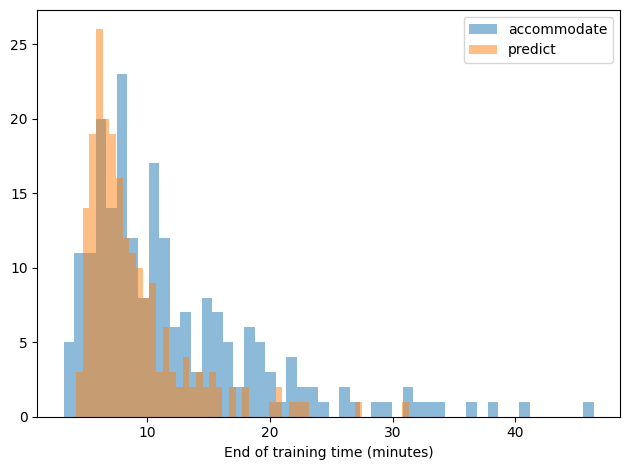

In [10]:
#Look at average time across task
df_combined['trial_stop_time'].describe()
avg_time = df_combined.groupby(['task'])['trial_stop_time'].mean()
print(avg_time)

for task, subdf in df_combined.groupby('task'):
    plt.hist(
        subdf['trial_stop_time']/60,
        bins=50,
        alpha=0.5,
        label=task
    )

plt.xlabel('End of training time (minutes)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'Figure1TrialStopTimeByTask.png'))
plt.show()


**Primary Analysis #1**

Part 1: Model Parameter Score Complexity across conditions

In [11]:
import pandas as pd


#Loop through rows and determine model parameter score for each participant

participant_rows = []

for _, row in df_combined.iterrows():
    tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
    wing_yes = 1 if row['wing_discrete_slider.response'] == 'Yes' else 0
    color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0
    model_param_score = tail_yes + wing_yes + color_yes


    participant_rows.append({
        'participant': row['participant'],
        'task': row['task'],  # predict vs accommodate
        'model_param_score': model_param_score,
        'conditionOrder': row['conditionOrder'],
        'irrelevant_dim': row['irrelevant_dim'],
        'wing_high': row['wing_high'],
        'overfit': model_param_score == 3 #overfit if all 3 dimensions selected
    })

df_params = pd.DataFrame(participant_rows)

#Compare overfit vs not by condition
contingency = pd.crosstab(
    df_params['task'],
    df_params['overfit']
)

print(contingency)
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-square = {chi2:.3f}")
print(f"df = {dof}")
print(f"p-value = {p:.4f}")


overfit      False  True 
task                     
accommodate    116     93
predict        121     88
Chi-square = 0.156
df = 1
p-value = 0.6930


In [12]:
df_params['intuitive_relevance'] = (
    df_params['irrelevant_dim'] != 'wing'
).astype(int)

df_params['intuitive_direction'] = (
    df_params['wing_high'] == 'T'
).astype(int)

df_params['task'] = df_params['task'].astype('category')
df_params["overfit"] = df_params["overfit"].astype(int)
print(df_params)

     participant         task  model_param_score  conditionOrder  \
0              1  accommodate                  3             216   
1              2  accommodate                  2              31   
2              3  accommodate                  1             142   
3              4  accommodate                  1              18   
4              5  accommodate                  3              62   
..           ...          ...                ...             ...   
413          414      predict                  2             183   
414          415      predict                  2             178   
415          416      predict                  1             172   
416          417      predict                  3               4   
417          418      predict                  1              18   

    irrelevant_dim wing_high  overfit  intuitive_relevance  \
0             wing         N        1                    0   
1             tail         N        0                    1 

          task  intuitive_relevance  intuitive_direction  overfit_rate   n
0  accommodate                    0                    0      0.480769  52
1  accommodate                    0                    1      0.480769  52
2  accommodate                    1                    0      0.358491  53
3  accommodate                    1                    1      0.461538  52
4      predict                    0                    0      0.423077  52
5      predict                    0                    1      0.384615  52
6      predict                    1                    0      0.509434  53
7      predict                    1                    1      0.365385  52


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_1628/4069399916.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['task', 'intuitive_relevance', 'intuitive_direction'])


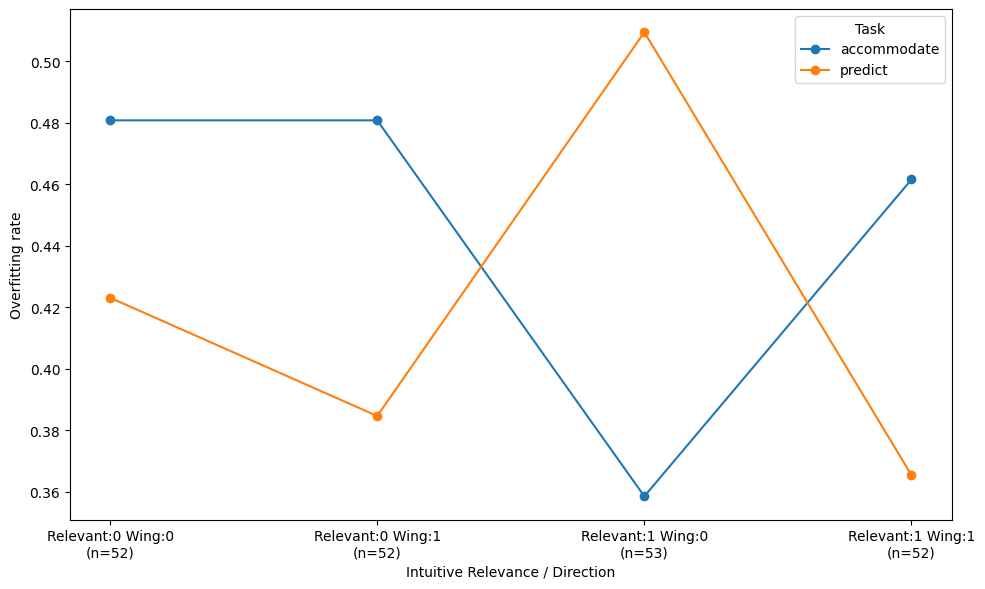

In [13]:
raw_summary = (
    df_params
    .groupby(['task', 'intuitive_relevance', 'intuitive_direction'])
    .agg(
        overfit_rate=('overfit', 'mean'),
        n=('overfit', 'size')
    )
    .reset_index()
)

print(raw_summary)

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))

for task in raw_summary['task'].unique():
    subset = raw_summary[raw_summary['task'] == task]
    
    x = np.arange(len(subset))
    ax.plot(x, subset['overfit_rate'], marker='o', label=task)

ax.set_xticks(x)
ax.set_xticklabels([
    f"Relevant:{r} Wing:{d}\n(n={n})"
    for r, d, n in zip(subset['intuitive_relevance'],
                       subset['intuitive_direction'],
                       subset['n'])
])

ax.set_ylabel("Overfitting rate")
ax.set_xlabel("Intuitive Relevance / Direction")
ax.legend(title="Task")
plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'Figure2OverfittingRateByTask.png'))
plt.show()

In [25]:
import statsmodels.formula.api as smf

model = smf.logit(
    formula="""
        overfit ~ task * intuitive_relevance * intuitive_direction
    """,
    data=df_params
).fit()

results_df = pd.DataFrame({
    "coef": model.params,
    "std_err": model.bse,
    "z": model.tvalues,
    "p_value": model.pvalues,
    "conf_low": model.conf_int()[0],
    "conf_high": model.conf_int()[1]
})

# Save to CSV
results_df.to_csv(os.path.join(outputdir, "Figure2OverfittingRatebyTaskStats.csv"))

Optimization terminated successfully.
         Current function value: 0.678039
         Iterations 4


Part 2: Testing distribution of all model parameter scores by task

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_params['task'] = df_params['task'].astype('category')
df_params['intuitive_relevance'] = (df_params['irrelevant_dim'] != 'wing').astype(int)
df_params['intuitive_direction'] = (df_params['wing_high'] == 'T').astype(int)

# Count occurrences of each score in each category
score_counts = (
    df_params
    .groupby(['task', 'intuitive_relevance', 'intuitive_direction', 'model_param_score'])
    .size()
    .reset_index(name='count')
)

# Pivot to have scores as columns
score_pivot = score_counts.pivot_table(
    index=['task', 'intuitive_relevance', 'intuitive_direction'],
    columns='model_param_score',
    values='count',
    fill_value=0
).reset_index()

print(score_pivot)

model_param_score         task  intuitive_relevance  intuitive_direction    0  \
0                  accommodate                    0                    0  2.0   
1                  accommodate                    0                    1  2.0   
2                  accommodate                    1                    0  5.0   
3                  accommodate                    1                    1  1.0   
4                      predict                    0                    0  3.0   
5                      predict                    0                    1  2.0   
6                      predict                    1                    0  4.0   
7                      predict                    1                    1  2.0   

model_param_score    1     2     3  
0                  6.0  19.0  25.0  
1                  9.0  16.0  25.0  
2                  6.0  23.0  19.0  
3                  5.0  22.0  24.0  
4                  6.0  21.0  22.0  
5                  8.0  22.0  20.0  
6          

/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_1628/4046063049.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['task', 'intuitive_relevance', 'intuitive_direction', 'model_param_score'])
/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_1628/4046063049.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  score_pivot = score_counts.pivot_table(


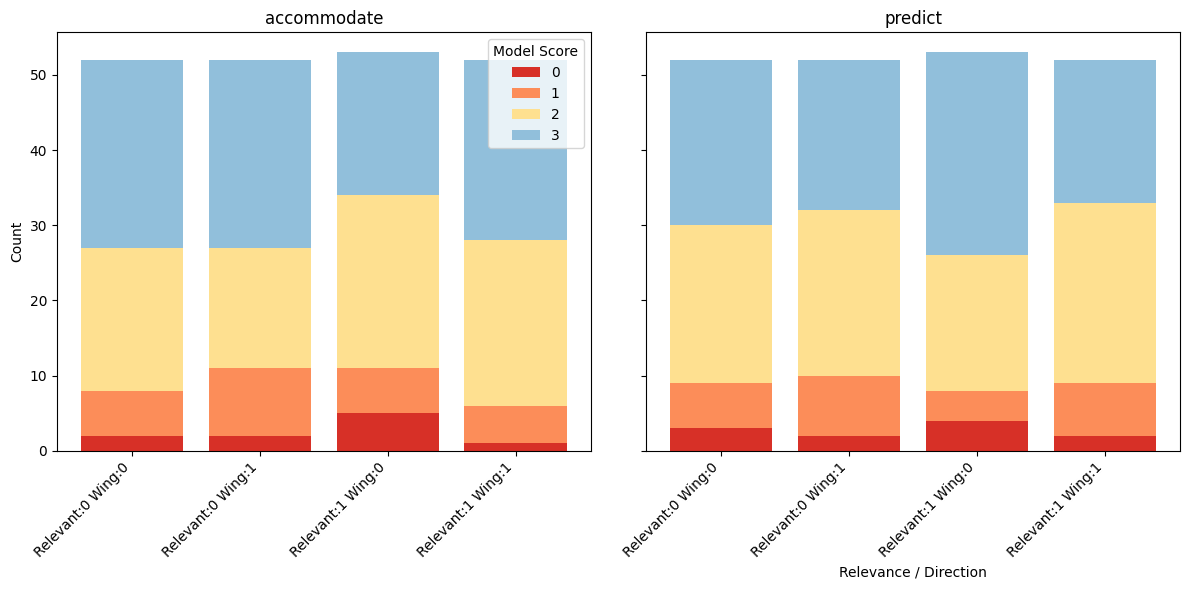

In [16]:
tasks = df_params['task'].cat.categories  # ['accommodate', 'predict']
buckets = sorted(df_params['model_param_score'].unique())
colors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb']  # one color per score

# Create subplots, one per task
fig, axes = plt.subplots(1, len(tasks), figsize=(12,6), sharey=True)

if len(tasks) == 1:
    axes = [axes]  # ensure axes is iterable if only 1 task

for ax, task in zip(axes, tasks):
    # Filter for this task
    task_data = score_pivot[score_pivot['task'] == task]
    
    x = np.arange(len(task_data))
    bottom = np.zeros(len(task_data))
    
    for i, b in enumerate(buckets):
        ax.bar(
            x,
            task_data[b],
            bottom=bottom,
            label=f"{b}" if ax == axes[0] else "",  # only show legend on first subplot
            color=colors[i]
        )
        bottom += task_data[b].values
    
    # X-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels([
        f"Relevant:{row['intuitive_relevance']} Wing:{row['intuitive_direction']}"
        for _, row in task_data.iterrows()
    ], rotation=45, ha='right')
    
    ax.set_title(task)

axes[0].set_ylabel("Count")
axes[-1].set_xlabel("Relevance / Direction")
axes[0].legend(title="Model Score")
plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'Figure3ModelParamScoreDistributionByTask.png'))
plt.show()

In [17]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Convert task to numeric (0 = accommodate, 1 = predict)
df_params['task_num'] = (df_params['task'] == 'predict').astype(int)

# Define predictors
exog = df_params[['task_num', 'intuitive_relevance', 'intuitive_direction']]

# add interaction terms
exog['task_relevance'] = exog['task_num'] * exog['intuitive_relevance']
exog['task_direction'] = exog['task_num'] * exog['intuitive_direction']
exog['relevance_direction'] = exog['intuitive_relevance'] * exog['intuitive_direction']
exog['task_relevance_direction'] = (
    exog['task_num'] * exog['intuitive_relevance'] * exog['intuitive_direction']
)


# Fit the ordinal regression model
model = OrderedModel(
    df_params['model_param_score'],
    exog,
    distr='logit'
)
res = model.fit(method='bfgs')

print(res.summary())

Optimization terminated successfully.
         Current function value: 1.130889
         Iterations: 44
         Function evaluations: 45
         Gradient evaluations: 45
                             OrderedModel Results                             
Dep. Variable:      model_param_score   Log-Likelihood:                -472.71
Model:                   OrderedModel   AIC:                             965.4
Method:            Maximum Likelihood   BIC:                             1006.
Date:                Fri, 13 Feb 2026                                         
Time:                        10:46:03                                         
No. Observations:                 418                                         
Df Residuals:                     408                                         
Df Model:                           7                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------

/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_1628/1937512157.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog['task_relevance'] = exog['task_num'] * exog['intuitive_relevance']
/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_1628/1937512157.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog['task_direction'] = exog['task_num'] * exog['intuitive_direction']
/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_1628/1937512157.py:13: SettingWithCopyWarning: 
A val

In [18]:
contingency_all = pd.crosstab(
    df_params['task'],
    df_params['model_param_score']
)

print(contingency_all)

chi2, p, dof, expected = chi2_contingency(contingency_all)

print(f"Chi-square = {chi2:.3f}")
print(f"df = {dof}")
print(f"p-value = {p:.4f}")

ax = contingency_all.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel("Task")
ax.set_ylabel("Count")
#ax.set_title("Model Parameter Scores by Task")

# Add numerical labels with the count
for container in ax.containers:
    ax.bar_label(
        container,
        label_type="center",
        fontsize=9
    )
plt.legend(title="Model parameter score", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
'''
plt.savefig(
    os.path.join(outputdir, "Figure2_TaskByModelParamScore_StackedBars.png"),
    dpi=300
)
'''
plt.close()

#Function of condition, wing relevance, and wing direction - the full distribution across that 
#code explanations later


model_param_score   0   1   2   3
task                             
accommodate        10  26  80  93
predict            11  25  85  88
Chi-square = 0.357
df = 3
p-value = 0.9490


**Primary Analysis #2: Predicting Feature Importance Ratings**

In [19]:
#Create map from short codes to feature descriptions

wing_map = {
    'wings': 't',
    'paws': 'n'
}

color_map = {
    'blue': 'b',
    'yellow': 'y'
}

tail_map = {
    'curly': 'c',
    'straight': 's'
}


feature_maps = {
    'wing': wing_map,
    'color': color_map,
    'tail': tail_map
}


In [20]:
#Compute feature importance scores

from doctest import debug


def compute_feature_importance_from_df(df):
    """
    Compute numeric feature importance scores(-7 to 7) for each participant,
    based on the saved slider_responses and the feature _high/_low mapping.
    This is computed based on whether a feature was really relevant (positive sign) or irrelevant (negative sign).
    0 = no response or feature was not thought to be relevant
    columns:
      - wings_discrete_slider.response, wings_direction_slider.response, wings_continuous_slider.response
      - color_discrete_slider.response, ...
      - tail_discrete_slider.response, ...
      - wings_high, wings_low, color_high, color_low, tail_high, tail_low
    """
    features = ['wing', 'color', 'tail']
    
    def compute_row_importance(row, feat):
        disc = row[f'{feat}_discrete_slider.response']
        dirc = row[f'{feat}_direction_slider.response']
        cont = row[f'{feat}_continuous_slider.response']

        #If they said a feature wasn't relevant, then importance is 0
        
        if disc == 'No' or pd.isna(disc):
            return 0.0
        
        # Make sure continuous slider value exists, if not, set it to 0
        cont_val = float(cont) if not pd.isna(cont) else 0.0

        # Get mapping from long to short feature name
        mapping = feature_maps.get(feat, {})

        # Normalize strings: strip whitespace, collapse multiple spaces, lower-case
        def normalize_str(s):
            """Strip leading/trailing whitespace and collapse internal multiple spaces."""

            if isinstance(s, str):
                return " ".join(s.split()).lower()
            return ""
        

        #Name of features need to be normalized for comparison using the mapping
        dirc_norm = normalize_str(dirc)

        #Get internal short code for selected feature direction
        internal_dirc = mapping.get(dirc_norm, None)
        
        high_val = normalize_str(row[f'{feat}_high'])
        low_val  = normalize_str(row[f'{feat}_low'])
        

        
        # Debug print statement (make sure mappings look right)
        debug = True
        if debug:
            print('response:', repr(dirc_norm), 'internal:', repr(internal_dirc), 
                'high:', repr(high_val), 'low:', repr(low_val))
            

        #If they correctly selected the high feature, assign positive sign
        if internal_dirc == high_val:
            sign = 1
        #If they incorrectly selected the low feature, assign negative sign
        elif internal_dirc == low_val:
            if debug:
                print('in negative')
            sign = -1
        else:
            if debug:
                print('in empty')
            sign = 0
            cont_val = 0.0

        # Add sign to continuous value
        importance = cont_val * sign

        return importance

    
    # Compute for each feature
    for feat in features:
        df[f'{feat}_importance'] = df.apply(lambda row: compute_row_importance(row, feat), axis=1)
    
    return df

df_combined = compute_feature_importance_from_df(df_combined)
if debug:
    print(df_combined['wing_importance'])

response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 't' low: 'n'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 't' low: 'n'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 'n' low: 't'
in negative
response: 'paws' internal: 'n' high: 't' low: 'n'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 'n' low: 't'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n'

In [21]:
import pandas as pd
"""Reshape to long format with 1 row per participant x feature dimension"""
# Keep only necessary columns
cols_to_keep = [
    'participant', 'task', 
    'wing_importance', 'color_importance', 'tail_importance',
    'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'wing_high','wing_discrete_slider.response'
]

df_long = df_combined[cols_to_keep].copy()

# Melt importance columns
df_long = df_long.melt(
    id_vars=['participant', 'task', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'wing_high', 'wing_discrete_slider.response'],
    value_vars=['wing_importance', 'color_importance', 'tail_importance'],
    var_name='feature_dimension',
    value_name='feature_importance'
)

# Simplify feature dimension names
df_long['feature_dimension'] = df_long['feature_dimension'].str.replace('_importance','')

def get_relevance(row):
    if row['feature_dimension'] in [row['relevant_dim_1'], row['relevant_dim_2']]:
        return 'relevant'
    else:
        return 'irrelevant'

df_long['feature_relevance'] = df_long.apply(get_relevance, axis=1)

print(df_long)

      participant         task relevant_dim_1 relevant_dim_2 irrelevant_dim  \
0               1  accommodate           tail          color           wing   
1               2  accommodate          color           wing           tail   
2               3  accommodate          color           tail           wing   
3               4  accommodate          color           tail           wing   
4               5  accommodate          color           tail           wing   
...           ...          ...            ...            ...            ...   
1249          414      predict          color           wing           tail   
1250          415      predict           tail          color           wing   
1251          416      predict          color           tail           wing   
1252          417      predict          color           tail           wing   
1253          418      predict          color           tail           wing   

     wing_high wing_discrete_slider.response featur

In [24]:
import statsmodels.formula.api as smf
df_overfit = df_long[df_long["feature_dimension"] == "wing"].copy()
df_overfit["wing_relevant"] = (df_overfit["feature_relevance"] == "relevant").astype(int) #Code relevancy as 0/1
df_overfit["wing_high"] = (df_overfit["wing_high"] == "T").astype(int) #Code having a wing as 0/1
df_overfit["wing_response"] = (df_overfit["wing_discrete_slider.response"] == "Yes").astype(int) #Code saying wing is relevant as 0/1
model = smf.logit(
    formula="""
        wing_response ~ task * wing_relevant * wing_high
    """,
    data=df_overfit
).fit()

print(model.summary())

summary_table = model.summary2().tables[1]

# Save to CSV
summary_table.to_csv(os.path.join(outputdir, "Figure4Stats.csv"))


Optimization terminated successfully.
         Current function value: 0.578752
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          wing_response   No. Observations:                  418
Model:                          Logit   Df Residuals:                      410
Method:                           MLE   Df Model:                            7
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:                 0.02380
Time:                        10:49:29   Log-Likelihood:                -241.92
converged:                       True   LL-Null:                       -247.82
Covariance Type:            nonrobust   LLR p-value:                    0.1074
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.9029

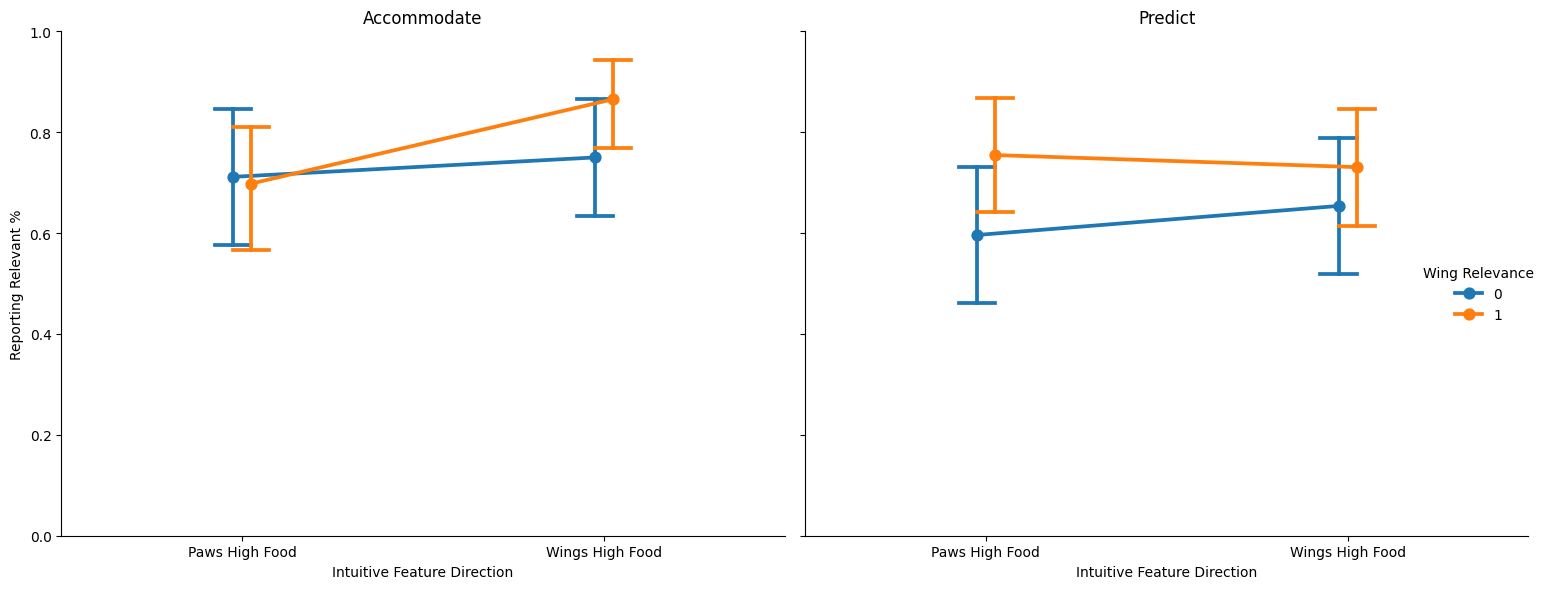

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create the catplot
g = sns.catplot(
    data=df_overfit, 
    x="wing_high",
    y="wing_response",
    hue="wing_relevant",
    col="task",
    kind="point",
    dodge=True,
    capsize=0.1,   # adds small caps to error bars, similar to errorbar plot
    markers="o",
    height=6,
    aspect=1.2
)

# Set axis limits
g.set(ylim=(0,1))

# Set axis labels
g.set_axis_labels("Intuitive Feature Direction", "Reporting Relevant %")

# Adjust x-tick labels for all subplots
for ax in g.axes.flatten():
    ax.set_xticks([0,1])
    ax.set_xticklabels(["Paws High Food", "Wings High Food"])
    ax.set_title(ax.get_title().split(' = ')[-1].capitalize())  # format task titles

# Adjust legend title
g._legend.set_title("Wing Relevance")

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(outputdir, 'Figure4WingRelevanceByTask.png'))
plt.show()


In [188]:
print(df_long.groupby('feature_dimension')['feature_relevance'].describe())

                  count unique       top freq
feature_dimension                            
color               418      2  relevant  314
tail                418      2  relevant  312
wing                418      2  relevant  210


WING — relevant: 210 points
WING — irrelevant: 208 points
TAIL — relevant: 312 points
TAIL — irrelevant: 106 points
COLOR — relevant: 314 points
COLOR — irrelevant: 104 points


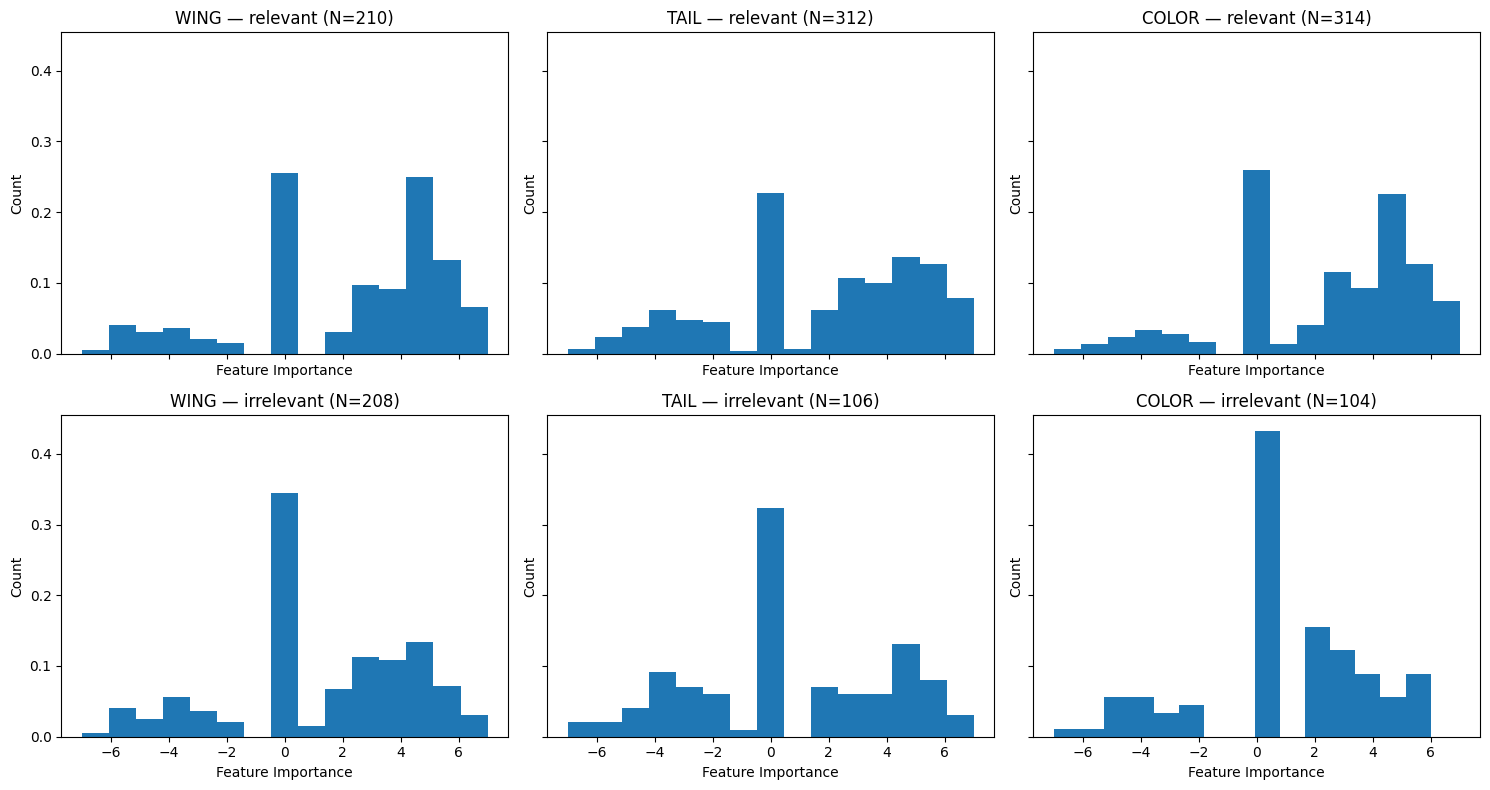

In [189]:
import matplotlib.pyplot as plt

features = ['wing', 'tail', 'color']
relevance_states = ['relevant', 'irrelevant']

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

for col, feat in enumerate(features):
    for row, rel in enumerate(relevance_states):
        
        ax = axes[row, col]
        
        subset = df_long[
            (df_long['feature_dimension'] == feat) &
            (df_long['feature_relevance'] == rel)
        ]
        
        # Number of rows in this subset
        n_points = len(subset)
        print(f"{feat.upper()} — {rel}: {n_points} points")
        
        ax.hist(subset['feature_importance'], bins=15, density=True)
        ax.set_title(f"{feat.upper()} — {rel} (N={n_points})")
        ax.set_xlabel("Feature Importance")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [28]:
df_wing = df_long[df_long["feature_dimension"] == "wing"].copy()
df_wing["wing_relevant"] = (df_wing["feature_relevance"] == "relevant").astype(int) #Code relevancy as 0/1
df_wing["wing_high"] = (df_wing["wing_high"] == "T").astype(int) #Code having a wing as 0/1
print(df_wing)

     participant         task relevant_dim_1 relevant_dim_2 irrelevant_dim  \
0              1  accommodate           tail          color           wing   
1              2  accommodate          color           wing           tail   
2              3  accommodate          color           tail           wing   
3              4  accommodate          color           tail           wing   
4              5  accommodate          color           tail           wing   
..           ...          ...            ...            ...            ...   
413          414      predict          color           wing           tail   
414          415      predict           tail          color           wing   
415          416      predict          color           tail           wing   
416          417      predict          color           tail           wing   
417          418      predict          color           tail           wing   

     wing_high wing_discrete_slider.response feature_dimension 

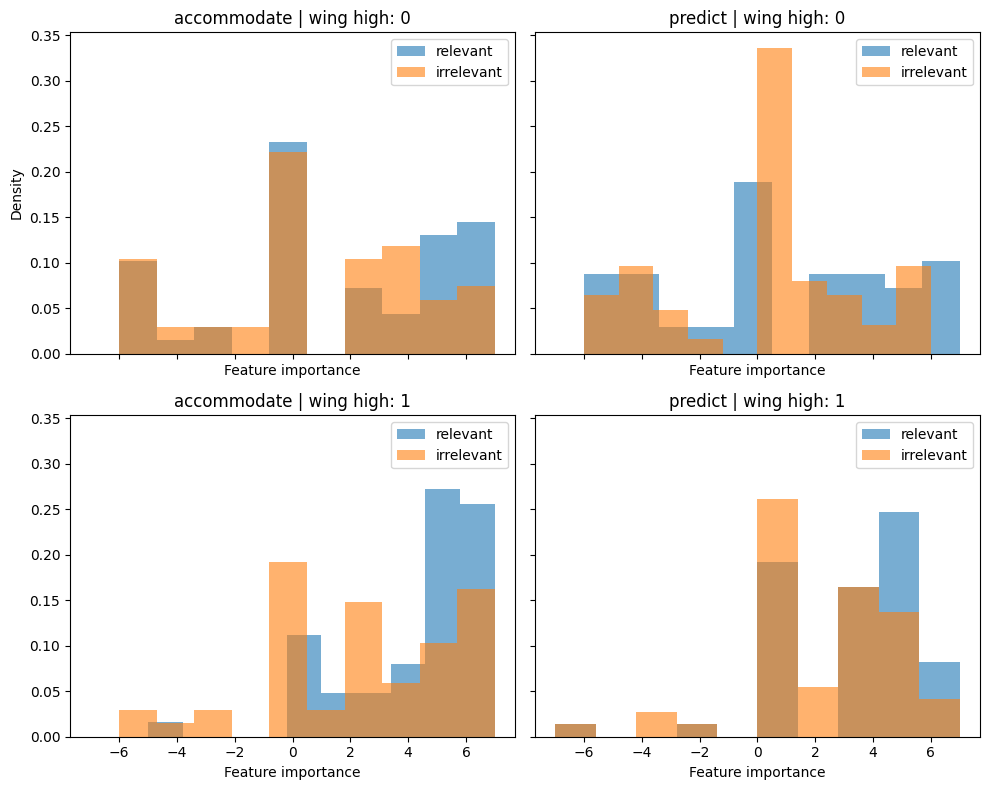

In [29]:
import matplotlib.pyplot as plt

tasks = df_wing['task'].unique()
wing_high_states = df_wing['wing_high'].unique()

fig, axes = plt.subplots(
    nrows=len(wing_high_states),
    ncols=len(tasks),
    figsize=(5 * len(tasks), 4 * len(wing_high_states)),
    sharey=True,
    sharex=True
)

# Handle case where rows/cols == 1
if len(wing_high_states) == 1:
    axes = [axes]

for row, wing_high in enumerate(wing_high_states):
    for col, task in enumerate(tasks):
        ax = axes[row][col] if len(tasks) > 1 else axes[row]

        for label in ['relevant', 'irrelevant']:
            values = df_wing.loc[
                (df_wing['task'] == task) &
                (df_wing['wing_high'] == wing_high) &
                (df_wing['feature_relevance'] == label),
                'feature_importance'
            ]
            
            ax.hist(values, bins=10, alpha=0.6, density=True, label=label)

        ax.set_title(f"{task} | wing high: {wing_high}")
        ax.set_xlabel("Feature importance")
        ax.legend()

axes[0][0].set_ylabel("Density")

plt.tight_layout()
plt.show()

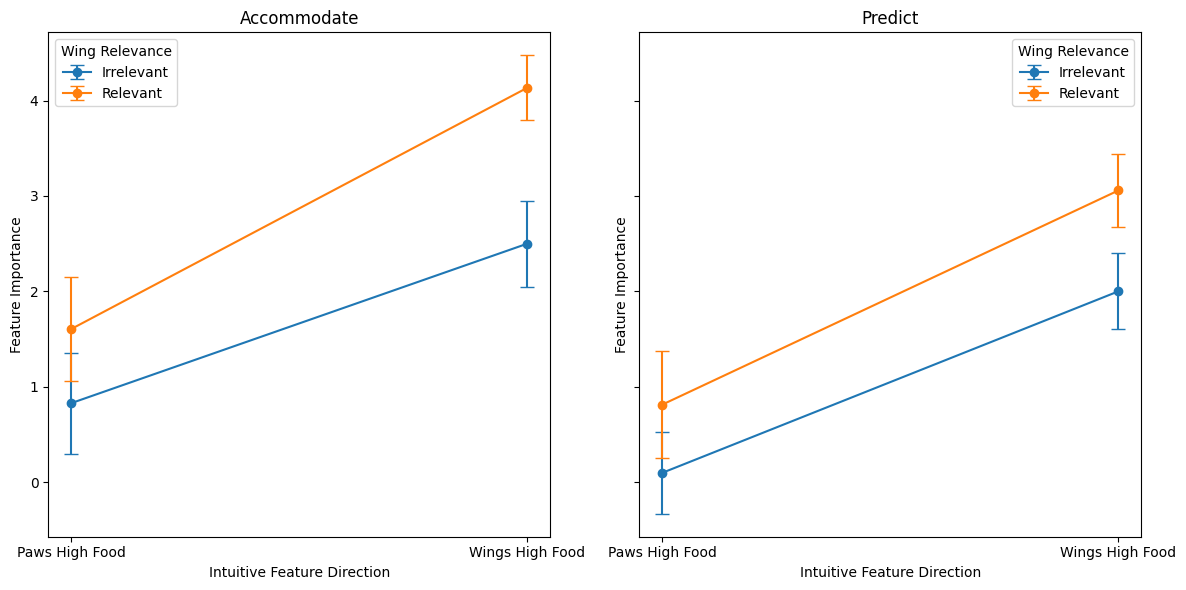

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

for i, task in enumerate(df_wing["task"].unique()):
    ax = axes[i]
    
    task_df = df_wing[df_wing["task"] == task]

    for rel in [0, 1]:  # irrelevant / relevant
        rel_df = task_df[task_df["wing_relevant"] == rel]
        
        means = []
        ses = []

        for present in [0, 1]:  # paws high / wings high
            cell = rel_df[rel_df["wing_high"] == present]["feature_importance"]
            
            means.append(cell.mean())
            ses.append(cell.std() / np.sqrt(len(cell)))

        label = "Relevant" if rel == 1 else "Irrelevant"
        ax.errorbar([0,1], means, yerr=ses, marker='o', capsize=5, label=label)

    ax.set_title(task.capitalize())
    ax.set_xticks([0,1])
    ax.set_xticklabels(["Paws High Food", "Wings High Food"])
    ax.set_xlabel("Intuitive Feature Direction")
    ax.set_ylabel("Feature Importance")
    ax.legend(title="Wing Relevance")

plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'Figure5WingFeatureImportanceByTask.png'))
plt.show()

In [238]:
means = (
    df_wing
    .groupby(["task", "wing_relevant", "wing_high"])["feature_importance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print(means)


          task  wing_relevant  wing_high      mean       std  count
0  accommodate              0          0  0.826923  3.802585     52
1  accommodate              0          1  2.500000  3.250943     52
2  accommodate              1          0  1.603774  3.953283     53
3  accommodate              1          1  4.134615  2.457712     52
4      predict              0          0  0.096154  3.088623     52
5      predict              0          1  2.000000  2.876545     52
6      predict              1          0  0.811321  4.081179     53
7      predict              1          1  3.057692  2.782392     52


In [239]:
means = (
    df_wing
    .groupby(["task", "wing_high"])["feature_importance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print(means)


          task  wing_high      mean       std  count
0  accommodate          0  1.219048  3.880377    105
1  accommodate          1  3.317308  2.983008    104
2      predict          0  0.457143  3.624247    105
3      predict          1  2.528846  2.865790    104


In [240]:
means = (
    df_wing
    .groupby(["task", "wing_relevant"])["feature_importance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print(means)


          task  wing_relevant      mean       std  count
0  accommodate              0  1.663462  3.619286    104
1  accommodate              1  2.857143  3.520349    105
2      predict              0  1.048077  3.120181    104
3      predict              1  1.923810  3.660326    105


In [31]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "feature_importance ~ task + wing_relevant + wing_high + task:wing_relevant + task:wing_high + wing_relevant:wing_high + task:wing_relevant:wing_high",
    df_wing,
    groups=df_wing["participant"]
).fit()

print(model.summary())
model.summary().tables[1].to_csv(os.path.join(outputdir, "Figure5mixedlm_featureimportanceStats.csv"))


                      Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       feature_importance
No. Observations:       418           Method:                   REML              
No. Groups:             418           Scale:                    5.5691            
Min. group size:        1             Log-Likelihood:           -1091.7158        
Max. group size:        1             Converged:                Yes               
Mean group size:        1.0                                                       
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                0.827    0.462  1.790 0.073 -0.079  1.732
task[T.predict]                         -0.731    0.639 -1.143 0.253 -1.984  0.522
wing_relevant              

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [36]:
# Full model
model_full = smf.mixedlm(
    "feature_importance ~ task * wing_relevant * wing_high",
    df_wing,
    groups=df_wing["participant"]
).fit()

# Reduced model (no 3-way)
model_reduced = smf.mixedlm(
    "feature_importance ~ task * wing_relevant + task * wing_high + wing_relevant * wing_high",
    df_wing,
    groups=df_wing["participant"]
).fit()

print(model_reduced.summary())


                    Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     feature_importance
No. Observations:      418         Method:                 REML              
No. Groups:            418         Scale:                  5.5576            
Min. group size:       1           Log-Likelihood:         -1092.9791        
Max. group size:       1           Converged:              Yes               
Mean group size:       1.0                                                   
-----------------------------------------------------------------------------
                              Coef.     Std.Err.     z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                      0.762         0.432  1.763 0.078 -0.085  1.610
task[T.predict]               -0.601         0.566 -1.063 0.288 -1.710  0.508
wing_relevant                  0.905         0.564  1.605 0.109 -0.200  2.010
task[T

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [256]:
import statsmodels.formula.api as smf
import os

model = smf.ols(
    formula="""
        feature_importance ~ task * wing_relevant * wing_high
    """,
    data=df_wing
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     feature_importance   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     8.271
Date:                Thu, 12 Feb 2026   Prob (F-statistic):           1.89e-09
Time:                        13:30:28   Log-Likelihood:                -1092.8
No. Observations:                 418   AIC:                             2202.
Df Residuals:                     410   BIC:                             2234.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [32]:
subset = df_wing[
    (df_wing["wing_high"] == 1) &
    (df_wing["wing_relevant"] == 1)
]

model_task = smf.ols(
    "feature_importance ~ task",
    data=subset
).fit()

print(model_task.summary())


                            OLS Regression Results                            
Dep. Variable:     feature_importance   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4.376
Date:                Fri, 13 Feb 2026   Prob (F-statistic):             0.0389
Time:                        10:51:32   Log-Likelihood:                -246.93
No. Observations:                 104   AIC:                             497.9
Df Residuals:                     102   BIC:                             503.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1346      0.364     

In [248]:
df_wingAbs = df_wing.copy()
df_wingAbs["abs_feature_importance"] = df_wingAbs["feature_importance"].abs()

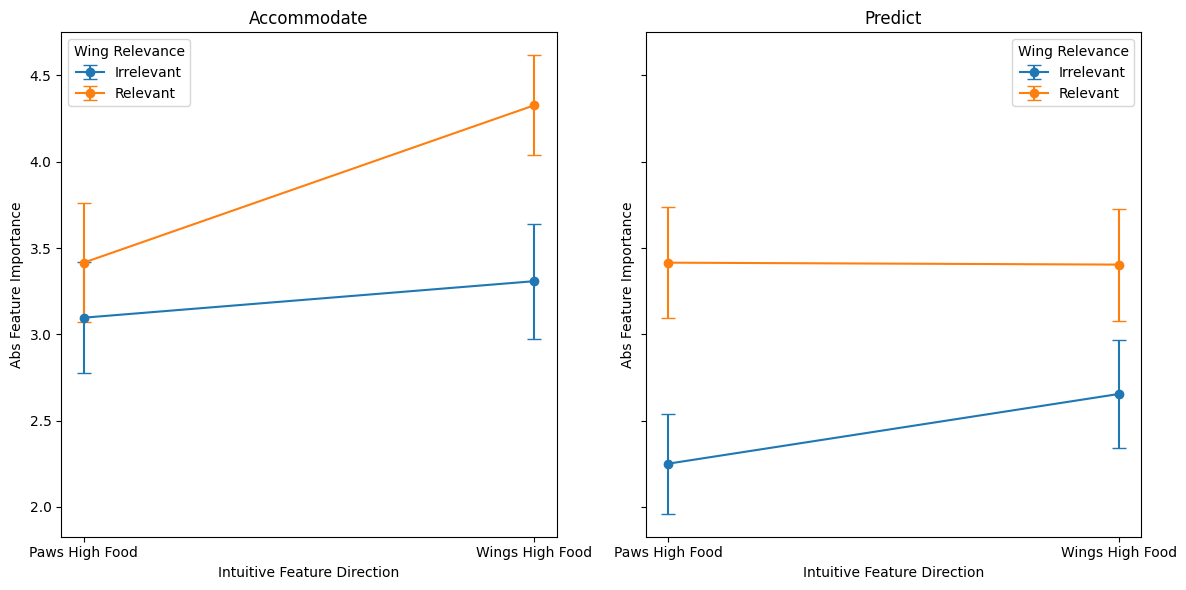

In [273]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

for i, task in enumerate(df_wingAbs["task"].unique()):
    ax = axes[i]
    
    task_df = df_wingAbs[df_wingAbs["task"] == task]

    for rel in [0, 1]:  # irrelevant / relevant
        rel_df = task_df[task_df["wing_relevant"] == rel]
        
        means = []
        ses = []

        for present in [0, 1]:  # paws high / wings high
            cell = rel_df[rel_df["wing_high"] == present]["abs_feature_importance"]
            
            means.append(cell.mean())
            ses.append(cell.std() / np.sqrt(len(cell)))

        label = "Relevant" if rel == 1 else "Irrelevant"
        ax.errorbar([0,1], means, yerr=ses, marker='o', capsize=5, label=label)

    ax.set_title(task.capitalize())
    ax.set_xticks([0,1])
    ax.set_xticklabels(["Paws High Food", "Wings High Food"])
    ax.set_xlabel("Intuitive Feature Direction")
    ax.set_ylabel("Abs Feature Importance")
    ax.legend(title="Wing Relevance")

plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'Figure6WingAbsFeatureImportanceByTask.png'))
plt.show()

In [271]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "abs_feature_importance ~ task + wing_relevant + wing_high + task:wing_relevant + task:wing_high + wing_relevant:wing_high + task:wing_relevant:wing_high",
    df_wingAbs,
    groups=df_wingAbs["participant"]
).fit()

print(model.summary())
model.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_absfeatureimportance.csv"))

                      Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     abs_feature_importance
No. Observations:       418         Method:                 REML                  
No. Groups:             418         Scale:                  2.6498                
Min. group size:        1           Log-Likelihood:         -939.4511             
Max. group size:        1           Converged:              Yes                   
Mean group size:        1.0                                                       
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                3.096    0.265 11.677 0.000  2.576  3.616
task[T.predict]                         -0.846    0.292 -2.899 0.004 -1.418 -0.274
wing_relevant              

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [252]:
import statsmodels.formula.api as smf
import os

model = smf.ols(
    formula="""
        abs_feature_importance ~ task * wing_relevant * wing_high
    """,
    data=df_wingAbs
).fit()

print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     abs_feature_importance   R-squared:                       0.059
Model:                                OLS   Adj. R-squared:                  0.043
Method:                     Least Squares   F-statistic:                     3.672
Date:                    Thu, 12 Feb 2026   Prob (F-statistic):           0.000734
Time:                            13:26:59   Log-Likelihood:                -937.61
No. Observations:                     418   AIC:                             1891.
Df Residuals:                         410   BIC:                             1924.
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [269]:
subset = df_wingAbs[
    (df_wingAbs["wing_high"] == 1) &
    (df_wingAbs["wing_relevant"] == 1)
]

model_task = smf.ols(
    "abs_feature_importance ~ task",
    data=subset
).fit()

print(model_task.summary())


                              OLS Regression Results                              
Dep. Variable:     abs_feature_importance   R-squared:                       0.042
Model:                                OLS   Adj. R-squared:                  0.033
Method:                     Least Squares   F-statistic:                     4.502
Date:                    Thu, 12 Feb 2026   Prob (F-statistic):             0.0363
Time:                            13:35:27   Log-Likelihood:                -229.42
No. Observations:                     104   AIC:                             462.8
Df Residuals:                         102   BIC:                             468.1
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
In

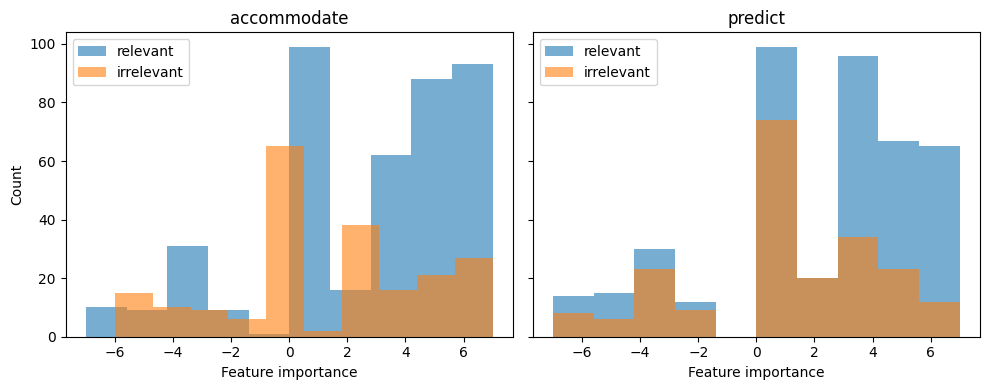

In [246]:
tasks = df_long['task'].unique()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tasks),
    figsize=(5 * len(tasks), 4),
    sharey=True
)

if len(tasks) == 1:
    axes = [axes]

for ax, task in zip(axes, tasks):
    for label in ['relevant', 'irrelevant']:
        values = df_long.loc[
            (df_long['task'] == task) &
            (df_long['feature_relevance'] == label),
            'feature_importance'
        ]
        ax.hist(values, bins=10, alpha=0.6, label=label)

    ax.set_title(task)
    ax.set_xlabel("Feature importance")
    ax.legend()

axes[0].set_ylabel("Count")

plt.tight_layout()
#plt.savefig(os.path.join(outputdir, 'Figure3_FeatureImportanceByTaskAndRelevance.png'), dpi=300)
plt.show()


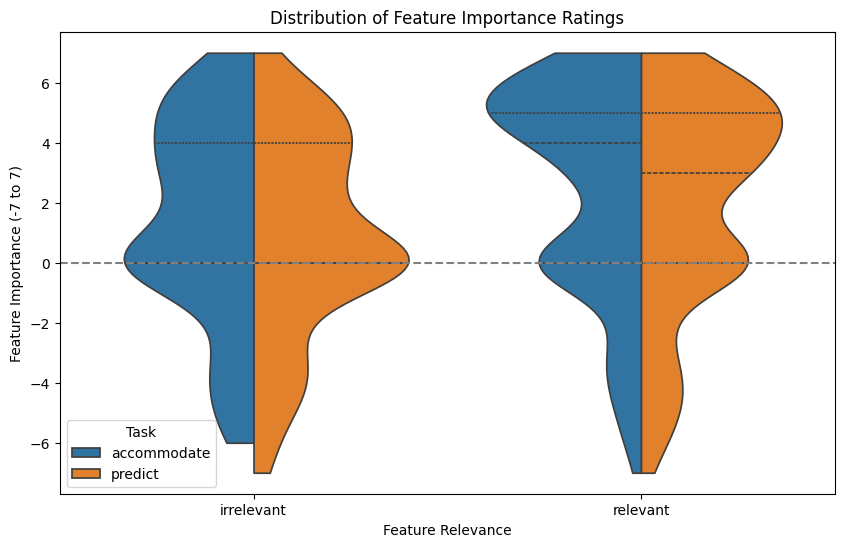

In [247]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Violin plot: distribution of ratings by task and relevance
sns.violinplot(
    data=df_long,
    x='feature_relevance',      # relevant / irrelevant
    y='feature_importance',     # -7 to 7
    hue='task',                 # predict / accomodate
    split=True,                 # split the violins by hue
    inner='quartile',            # show median and quartiles
    cut = 0
)

plt.axhline(0, color='gray', linestyle='--')  # line at 0
plt.title('Distribution of Feature Importance Ratings')
plt.ylabel('Feature Importance (-7 to 7)')
plt.xlabel('Feature Relevance')
plt.legend(title='Task')
#plt.savefig(os.path.join(outputdir, 'Figure4_FeatureImportanceByTaskAndRelevanceViolin.png'), dpi=300)
plt.show()


In [39]:
df_long['task'] = df_long['task'].astype('category')  # predict/accomodate
df_long['feature_dimension'] = df_long['feature_dimension'].astype('category')
df_long['feature_relevance'] = df_long['feature_relevance'].astype('category')


In [41]:
import statsmodels.formula.api as smf

# Predicting feature importance from task and feature relevance, with random intercepts for participants
md = smf.mixedlm(
    "feature_importance ~ task * feature_relevance",
    df_long,
    groups=df_long["participant"],  # random intercept per participant
    re_formula="~feature_relevance" # random slopes
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())
#mdf.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_featureimportance.csv"))

                         Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         feature_importance
No. Observations:         1317            Method:                     REML              
No. Groups:               439             Scale:                      11.6814           
Min. group size:          3               Log-Likelihood:             -3566.7150        
Max. group size:          3               Converged:                  Yes               
Mean group size:          3.0                                                           
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      1.273    0.239  5.333 0.000  0.805  1.740
task[T.predict]                               -

In [42]:
#Analyse the absolute value of feature importance ratings (ignoring direction)
df_longAbs = df_long.copy()
df_longAbs["abs_feature_importance"] = df_longAbs["feature_importance"].abs()
avg_importance_task = (
    df_longAbs
        .groupby(['task', 'feature_relevance'])['abs_feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance_task)
avg_importance_relevance = (
    df_longAbs
        .groupby(['feature_relevance'])['abs_feature_importance']
        .mean()
        .reset_index()
)

print(avg_importance_relevance)

avg_importance_feature = (
    df_longAbs
        .groupby(['feature_dimension'])['abs_feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance_feature)

          task feature_relevance  abs_feature_importance
0  accommodate        irrelevant                3.063636
1  accommodate          relevant                3.684091
2      predict        irrelevant                2.721461
3      predict          relevant                3.449772
  feature_relevance  abs_feature_importance
0        irrelevant                2.892938
1          relevant                3.567198
  feature_dimension  abs_feature_importance
0             color                3.248292
1              tail                3.405467
2              wing                3.373576


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_11746/1409563864.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['task', 'feature_relevance'])['abs_feature_importance']
/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_11746/1409563864.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['feature_relevance'])['abs_feature_importance']
/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_11746/1409563864.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

In [44]:
df_irrel = df_longAbs[df_longAbs["feature_relevance"] == "irrelevant"].copy()

accom_vals = df_irrel[df_irrel["task"]=="accommodate"]["abs_feature_importance"]
predict_vals = df_irrel[df_irrel["task"]=="predict"]["abs_feature_importance"]
mean_accom = np.mean(accom_vals)
mean_predict = np.mean(predict_vals)

print(f"Mean (accommodate) = {mean_accom:.3f}")
print(f"Mean (predict) = {mean_predict:.3f}")
t, p = ttest_ind(predict_vals, accom_vals, equal_var=False)  # Welch's t-test
print(f"t = {t:.3f}, p = {p:.4f}")
summary_df = pd.DataFrame({
    "task": ["accommodate", "predict"],
    "mean_abs_feature_importance": [mean_accom, mean_predict],
    "t_stat": [t, t], 
    "p_value": [p, p]    
})

# Save CSV
#summary_df.to_csv(os.path.join(outputdir, "ttest_abs_featureimportance.csv"))

Mean (accommodate) = 3.064
Mean (predict) = 2.721
t = -1.571, p = 0.1170


**Analysis 3: Predicting Food Consumption Ratings**

In [274]:
#Group by average food amount per item in training
df = df_combined[['task', 'training_image_order', 'food_amount', 'conditionOrder']]
df_long2 = (
    df
    .explode(['training_image_order', 'food_amount'])
    .rename(columns={'training_image_order': 'item'})
)
avg_food = (
    df_long2
    .groupby(['task', 'conditionOrder', 'item'], as_index=False)
    ['food_amount']
    .mean()
)
avg_food_train = avg_food.copy()
print(avg_food_train.head(20))


           task  conditionOrder   item food_amount
0   accommodate               1  N_B_C    4.333333
1   accommodate               1  N_B_S    2.666667
2   accommodate               1  N_Y_C    5.666667
3   accommodate               1  N_Y_S         4.0
4   accommodate               1  T_B_C    5.666667
5   accommodate               1  T_B_S    4.666667
6   accommodate               1  T_Y_C         7.0
7   accommodate               1  T_Y_S    5.666667
8   accommodate               3  N_B_C    5.333333
9   accommodate               3  N_B_S         4.0
10  accommodate               3  N_Y_C         7.0
11  accommodate               3  N_Y_S         7.0
12  accommodate               3  T_B_C    4.333333
13  accommodate               3  T_B_S         4.0
14  accommodate               3  T_Y_C    5.333333
15  accommodate               3  T_Y_S    3.666667
16  accommodate               4  N_B_C    4.666667
17  accommodate               4  N_B_S    5.333333
18  accommodate               4

In [275]:
#Get food consumption ratings by item

df = df_combined[['task', 'conditionOrder', 'testing_image_order', 'testing_responses', 'relevant_dim_1',
                  'relevant_dim_2', 'irrelevant_dim', 'color_high', 'tail_high', 'wing_high']]
df_long2 = (
    df
    .explode(['testing_image_order', 'testing_responses'])
    .rename(columns={'testing_image_order': 'item'})
)
avg_food_test = df_long2.copy()
print(avg_food_test)


            task  conditionOrder   item testing_responses relevant_dim_1  \
0    accommodate             216  T_B_S               7.0           tail   
0    accommodate             216  T_Y_S               6.0           tail   
0    accommodate             216  N_Y_S               6.0           tail   
0    accommodate             216  T_Y_C               3.0           tail   
0    accommodate             216  N_B_S               7.0           tail   
..           ...             ...    ...               ...            ...   
417      predict              18  T_B_C               8.0          color   
417      predict              18  T_Y_C               6.0          color   
417      predict              18  N_B_S               5.0          color   
417      predict              18  T_B_S               6.0          color   
417      predict              18  N_Y_C               4.0          color   

    relevant_dim_2 irrelevant_dim color_high tail_high wing_high  
0            color  

In [276]:
#Now merge the two (actual food amounts in training vs ratings in testing) and compute error
df_merged = avg_food_test.merge(
    avg_food_train,
    on=['task', 'conditionOrder', 'item'],
    how='left'
)

#Add Error and absolute error
df_merged['error'] = (
    df_merged['testing_responses'] - df_merged['food_amount']
)
df_merged['abs_error'] = df_merged['error'].abs()
df_merged[['wing', 'color', 'tail']] = df_merged['item'].str.split('_', expand=True)

print(df_merged)

             task  conditionOrder   item testing_responses relevant_dim_1  \
0     accommodate             216  T_B_S               7.0           tail   
1     accommodate             216  T_Y_S               6.0           tail   
2     accommodate             216  N_Y_S               6.0           tail   
3     accommodate             216  T_Y_C               3.0           tail   
4     accommodate             216  N_B_S               7.0           tail   
...           ...             ...    ...               ...            ...   
3339      predict              18  T_B_C               8.0          color   
3340      predict              18  T_Y_C               6.0          color   
3341      predict              18  N_B_S               5.0          color   
3342      predict              18  T_B_S               6.0          color   
3343      predict              18  N_Y_C               4.0          color   

     relevant_dim_2 irrelevant_dim color_high tail_high wing_high food_amou

In [277]:
print(df_merged[['food_amount', 'testing_responses', 'error']])

     food_amount testing_responses     error
0       6.666667               7.0  0.333333
1       4.333333               6.0  1.666667
2            6.0               6.0       0.0
3       3.333333               3.0 -0.333333
4            8.0               7.0      -1.0
...          ...               ...       ...
3339    5.666667               8.0  2.333333
3340    4.333333               6.0  1.666667
3341         8.0               5.0      -3.0
3342    6.333333               6.0 -0.333333
3343    2.333333               4.0  1.666667

[3344 rows x 3 columns]


In [278]:
#Sanity Check: Mean absolute error by feature (shouldn't be very different)

df_merged[['wing', 'color', 'tail']] = df_merged['item'].str.split('_', expand=True)

print("Mean error by tail:")
print(df_merged.groupby('tail')['error'].mean())

print("Mean error by color:")
print(df_merged.groupby('color')['error'].mean())

print("Mean error by wing:")
print(df_merged.groupby('wing')['error'].mean())
#t-test: color 1 vs color 2 absolute error 
color1 = df_merged.loc[df_merged['wing'] == 'N', 'error']
color2 = df_merged.loc[df_merged['wing'] == 'T', 'error']
t_stat, p_val = stats.ttest_ind(pd.to_numeric(color1), pd.to_numeric(color2), equal_var=False)  # Welch's t-test
print(f"T = {t_stat:.3f}, p = {p_val:.3f}")


Mean error by tail:
tail
C    0.393939
S   -0.022329
Name: error, dtype: object
Mean error by color:
color
B       0.125
Y    0.246611
Name: error, dtype: object
Mean error by wing:
wing
N   -0.058612
T    0.430223
Name: error, dtype: object
T = -8.557, p = 0.000


S
C


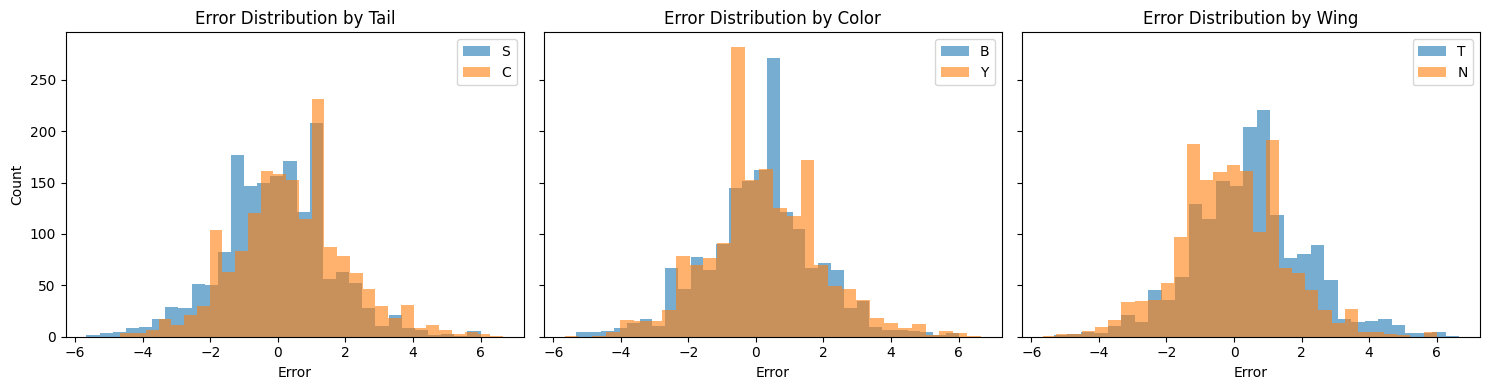

In [280]:
import matplotlib.pyplot as plt

# Make sure error is numeric
df_merged['error'] = pd.to_numeric(df_merged['error'])

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Tail
for t in df_merged['tail'].unique():
    print(t)
    axes[0].hist(
        df_merged.loc[df_merged['tail'] == t, 'error'],
        bins=30,
        alpha=0.6,
        label=t
    )
axes[0].set_title('Error Distribution by Tail')
axes[0].set_xlabel('Error')
axes[0].set_ylabel('Count')
axes[0].legend()

# --- Color ---
for c in df_merged['color'].unique():
    axes[1].hist(
        df_merged.loc[df_merged['color'] == c, 'error'],
        bins=30,
        alpha=0.6,
        label=c
    )
axes[1].set_title('Error Distribution by Color')
axes[1].set_xlabel('Error')
axes[1].legend()

# --- Wing ---
for w in df_merged['wing'].unique():
    axes[2].hist(
        df_merged.loc[df_merged['wing'] == w, 'error'],
        bins=30,
        alpha=0.6,
        label=w
    )
axes[2].set_title('Error Distribution by Wing')
axes[2].set_xlabel('Error')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'Figure7_ErrorDistributionByFeature.png'), dpi=300)
plt.show()


In [281]:
#Sanity Check: Mean absolute error by feature (shouldn't be very different)

df_merged[['wing', 'color', 'tail']] = df_merged['item'].str.split('_', expand=True)

print("Mean abs_error by tail:")
print(df_merged.groupby('tail')['abs_error'].mean())

print("Mean abs_error by color:")
print(df_merged.groupby('color')['abs_error'].mean())

print("Mean abs_error by wing:")
print(df_merged.groupby('wing')['abs_error'].mean())
#t-test: color 1 vs color 2 absolute error 
color1 = df_merged.loc[df_merged['color'] == 'B', 'abs_error']
color2 = df_merged.loc[df_merged['color'] == 'Y', 'abs_error']
t_stat, p_val = stats.ttest_ind(pd.to_numeric(color1), pd.to_numeric(color2), equal_var=False)  # Welch's t-test
print(f"T = {t_stat:.3f}, p = {p_val:.3f}")


Mean abs_error by tail:
tail
C    1.305024
S     1.24681
Name: abs_error, dtype: object
Mean abs_error by color:
color
B    1.262161
Y    1.289673
Name: abs_error, dtype: object
Mean abs_error by wing:
wing
N    1.227671
T    1.324163
Name: abs_error, dtype: object
T = -0.728, p = 0.467


In [282]:
#t-test: predict vs accomodate absolute error
df_merged['abs_error'] = pd.to_numeric(df_merged['abs_error'])
print(df_merged.groupby('task')['abs_error'].mean())
errors_task1 = df_merged.loc[df_merged['task'] == 'accommodate', 'abs_error']
errors_task2 = df_merged.loc[df_merged['task'] == 'predict', 'abs_error']
from scipy import stats
t_stat, p_val = stats.ttest_ind(errors_task1, errors_task2, equal_var=False)  # Welch's t-test
print(f"T = {t_stat:.3f}, p = {p_val:.3f}")
summary_df = pd.DataFrame({
    "task": ["accommodate", "predict"],
    "mean_abs_error": [errors_task1.mean(), errors_task2.mean()],
    "t_stat": [t_stat, t_stat], 
    "p_value": [p_val, p_val]    
})

# Save CSV
#summary_df.to_csv(os.path.join(outputdir, "ttest_error.csv"))

task
accommodate    1.287879
predict        1.263955
Name: abs_error, dtype: float64
T = 0.633, p = 0.527


Part 2: Correlations

In [283]:
print(df_merged.head(20))

           task  conditionOrder   item testing_responses relevant_dim_1  \
0   accommodate             216  T_B_S               7.0           tail   
1   accommodate             216  T_Y_S               6.0           tail   
2   accommodate             216  N_Y_S               6.0           tail   
3   accommodate             216  T_Y_C               3.0           tail   
4   accommodate             216  N_B_S               7.0           tail   
5   accommodate             216  T_B_C               4.0           tail   
6   accommodate             216  N_Y_C               5.0           tail   
7   accommodate             216  N_B_C               6.0           tail   
8   accommodate              31  T_B_S               2.0          color   
9   accommodate              31  N_Y_C               8.0          color   
10  accommodate              31  T_B_C               3.0          color   
11  accommodate              31  N_B_S               5.0          color   
12  accommodate          

In [284]:
# Columns indicating whether the item's feature is the "high" dimension (1 or 0 coding)
df_merged['tail_match_high']  = (df_merged['tail']  == df_merged['tail_high']).astype(int)
df_merged['color_match_high'] = (df_merged['color'] == df_merged['color_high']).astype(int)
df_merged['wing_match_high'] = (df_merged['wing'] == df_merged['wing_high']).astype(int)
#print(df_merged.head(20))
# Group by participant
participant_corrs = []

for pid, g in df_merged.groupby(['task', 'conditionOrder']):
    for feat in ['tail','color','wing']:
        # Column indicating match to high value
        match_col = f"{feat}_match_high"
        
        # Compute correlation
        corr = g['testing_responses'].corr(g[match_col])
        
        # Determine if this feature is relevant for this participant
        relevant = feat in [g['relevant_dim_1'].iloc[0], g['relevant_dim_2'].iloc[0]]
        high_col  = f"{feat}_high"
        
        # Store
        participant_corrs.append({
            'participant': pid,
            'task': g['task'].iloc[0],
            'feature_dimension': feat,
            'high_value': g[high_col].iloc[0],
            'feature_relevance': 'relevant' if relevant else 'irrelevant',
            'correlation': corr,
            'irrelevant_dim': g['irrelevant_dim'].iloc[0],
            'abs_correlation': abs(corr) if pd.notna(corr) else None
        })

df_corr = pd.DataFrame(participant_corrs)
print(df_corr.head(40))



          participant         task feature_dimension high_value  \
0    (accommodate, 1)  accommodate              tail          C   
1    (accommodate, 1)  accommodate             color          Y   
2    (accommodate, 1)  accommodate              wing          T   
3    (accommodate, 3)  accommodate              tail          C   
4    (accommodate, 3)  accommodate             color          Y   
5    (accommodate, 3)  accommodate              wing          N   
6    (accommodate, 4)  accommodate              tail          S   
7    (accommodate, 4)  accommodate             color          B   
8    (accommodate, 4)  accommodate              wing          T   
9    (accommodate, 5)  accommodate              tail          C   
10   (accommodate, 5)  accommodate             color          Y   
11   (accommodate, 5)  accommodate              wing          T   
12   (accommodate, 6)  accommodate              tail          S   
13   (accommodate, 6)  accommodate             color          

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [316]:
df_wing2 = df_corr[df_corr["feature_dimension"] == "wing"].copy()
df_wing2["wing_relevant"] = (df_wing2["feature_relevance"] == "relevant").astype(int) #Code relevancy as 0/1
df_wing2["wing_present"] = (df_wing2["high_value"] == "T").astype(int) #Code relevancy as 0/1

print(df_wing2)

           participant         task feature_dimension high_value  \
2     (accommodate, 1)  accommodate              wing          T   
5     (accommodate, 3)  accommodate              wing          N   
8     (accommodate, 4)  accommodate              wing          T   
11    (accommodate, 5)  accommodate              wing          T   
14    (accommodate, 6)  accommodate              wing          T   
...                ...          ...               ...        ...   
1241    (predict, 216)      predict              wing          N   
1244    (predict, 217)      predict              wing          T   
1247    (predict, 218)      predict              wing          T   
1250    (predict, 219)      predict              wing          N   
1253    (predict, 220)      predict              wing          N   

     feature_relevance  correlation irrelevant_dim  abs_correlation  \
2             relevant     0.875190          color         0.875190   
5             relevant     1.000000      

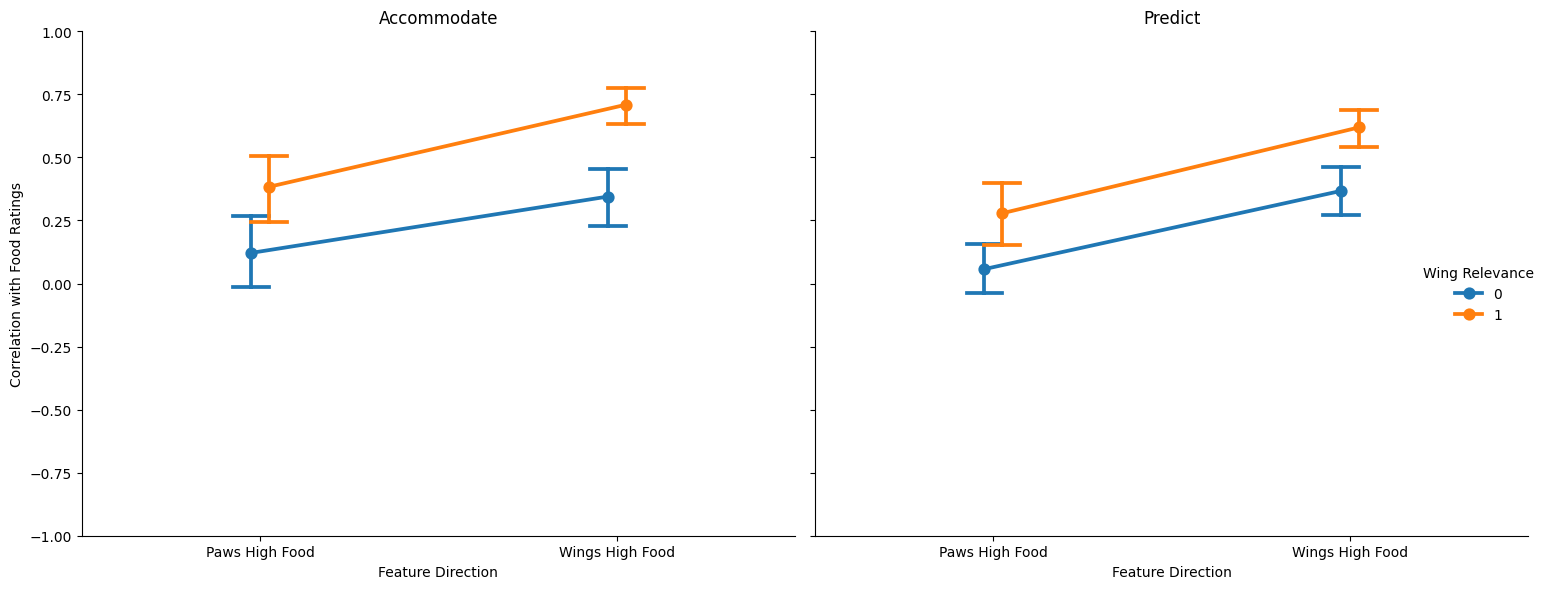

In [290]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

# Define x-axis labels
x_labels = ["Paws High Food", "Wings High Food"]

# Create catplot
g = sns.catplot(
    data=df_wing2,
    x="wing_present",
    y="correlation",
    hue="wing_relevant",
    col="task",
    kind="point",
    dodge=True,
    capsize=0.1,
    markers="o",
    height=6,
    aspect=1.2
)

# Set axis limits
g.set(ylim=(-1, 1))

# Set axis labels
g.set_axis_labels("Feature Direction", "Correlation with Food Ratings")

# Adjust x-tick labels and titles
for ax in g.axes.flatten():
    ax.set_xticks([0, 1])
    ax.set_xticklabels(x_labels)
    ax.set_title(ax.get_title().split(' = ')[-1].capitalize())  # clean task title

# Legend title
g._legend.set_title("Wing Relevance")

plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'Figure8WingCorrelationByTask.png'))
plt.show()


In [305]:
print(df_wing2)

           participant         task feature_dimension high_value  \
2     (accommodate, 1)  accommodate              wing          T   
5     (accommodate, 3)  accommodate              wing          N   
8     (accommodate, 4)  accommodate              wing          T   
11    (accommodate, 5)  accommodate              wing          T   
14    (accommodate, 6)  accommodate              wing          T   
...                ...          ...               ...        ...   
1241    (predict, 216)      predict              wing          N   
1244    (predict, 217)      predict              wing          T   
1247    (predict, 218)      predict              wing          T   
1250    (predict, 219)      predict              wing          N   
1253    (predict, 220)      predict              wing          N   

     feature_relevance  correlation irrelevant_dim  abs_correlation  \
2             relevant     0.875190          color         0.875190   
5             relevant     1.000000      

In [317]:
import statsmodels.formula.api as smf

# Convert categorical predictors
df_wing2["task"] = df_wing2["task"].astype('category')
df_wing2["wing_relevant"] = df_wing2["wing_relevant"].astype('category')
df_wing2["wing_present"] = df_wing2["wing_present"].astype('category')
df_wing2["participant"] = df_wing2["participant"].apply(lambda x: int(x[1]))
model_vars = ["correlation", "task", "wing_relevant", "wing_present", "participant"]
df_model = df_wing2[model_vars].dropna().copy()
df_model = df_model.reset_index(drop=True)
df_model = df_model.reset_index(drop=True)

# Fit model
model = smf.mixedlm(
    "correlation ~ task * wing_relevant * wing_present",
    data=df_model,
    groups=df_model["participant"]
)

result = model.fit(reml=False)
print(result.summary())


                             Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             correlation
No. Observations:               412                 Method:                         ML         
No. Groups:                     209                 Scale:                          0.1491     
Min. group size:                1                   Log-Likelihood:                 -201.9743  
Max. group size:                2                   Converged:                      Yes        
Mean group size:                2.0                                                            
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                             0.122    0.056 

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [287]:
avg_corr_task_rel = df_wing2.groupby(
    ['task', 'wing_present'],
    as_index=False
)['correlation'].mean()
print(avg_corr_task_rel)

          task  wing_present  correlation
0  accommodate             0     0.253719
1  accommodate             1     0.526822
2      predict             0     0.167956
3      predict             1     0.492109


In [288]:
avg_corr_task_rel = df_wing2.groupby(
    ['task', 'wing_relevant', 'wing_present'],
    as_index=False
)['correlation'].mean()
print(avg_corr_task_rel)

          task  wing_relevant  wing_present  correlation
0  accommodate              0             0     0.121405
1  accommodate              0             1     0.344812
2  accommodate              1             0     0.383440
3  accommodate              1             1     0.708833
4      predict              0             0     0.057273
5      predict              0             1     0.367453
6      predict              1             0     0.278638
7      predict              1             1     0.619209


In [59]:
avg_corr_task_rel = df_corr.groupby(
    ['task'],
    as_index=False
)['correlation'].mean()

print(avg_corr_task_rel)
avg_corr_feature = df_corr.groupby(
    ['feature_dimension'],
    as_index=False
)['correlation'].mean()

print(avg_corr_feature)
avg_corr_relevance = df_corr.groupby(
    ['feature_relevance'],
    as_index=False
)['correlation'].mean()

print(avg_corr_relevance)

          task  correlation
0  accommodate     0.282973
1      predict     0.249138
  feature_dimension  correlation
0             color     0.287023
1              tail     0.165848
2              wing     0.345060
  feature_relevance  correlation
0        irrelevant     0.149604
1          relevant     0.324164


In [60]:
avg_corr_feature = df_corr.groupby(
    ['task', 'feature_dimension'],
    as_index=False
)['correlation'].mean()
print(avg_corr_feature)


          task feature_dimension  correlation
0  accommodate             color     0.283880
1  accommodate              tail     0.183594
2  accommodate              wing     0.381445
3      predict             color     0.290137
4      predict              tail     0.148266
5      predict              wing     0.309011


In [61]:
avg_corr_task_rel = df_corr.groupby(
    ['task'],
    as_index=False
)['correlation'].mean()

print(avg_corr_task_rel)
avg_corr_feature = df_corr.groupby(
    ['feature_dimension'],
    as_index=False
)['correlation'].mean()

print(avg_corr_feature)
avg_corr_relevance = df_corr.groupby(
    ['feature_relevance'],
    as_index=False
)['correlation'].mean()

print(avg_corr_relevance)

          task  correlation
0  accommodate     0.282973
1      predict     0.249138
  feature_dimension  correlation
0             color     0.287023
1              tail     0.165848
2              wing     0.345060
  feature_relevance  correlation
0        irrelevant     0.149604
1          relevant     0.324164


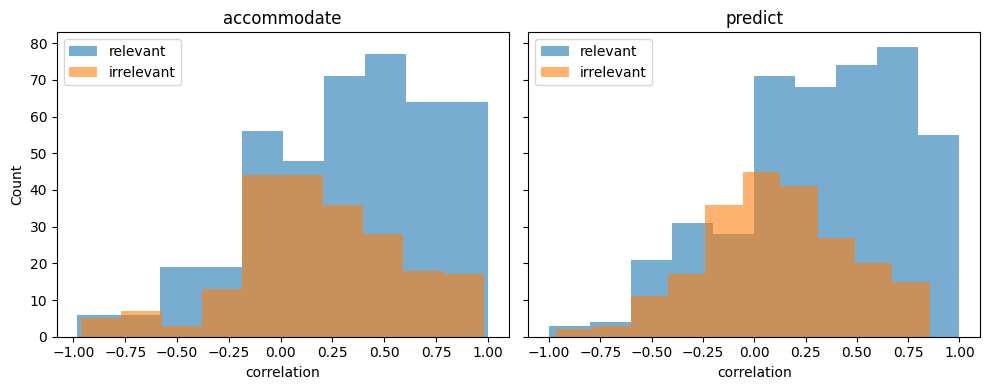

In [62]:
tasks = df_corr['task'].unique()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tasks),
    figsize=(5 * len(tasks), 4),
    sharey=True
)

if len(tasks) == 1:
    axes = [axes]

for ax, task in zip(axes, tasks):
    for label in ['relevant', 'irrelevant']:
        values = df_corr.loc[
            (df_corr['task'] == task) &
            (df_corr['feature_relevance'] == label),
            'correlation'
        ]
        ax.hist(values, bins=10, alpha=0.6, label=label)

    ax.set_title(task)
    ax.set_xlabel("correlation")
    ax.legend()

axes[0].set_ylabel("Count")

plt.tight_layout()
#plt.savefig(os.path.join(outputdir, 'Figure5_FeatureCorrelationeByTaskAndRelevance.png'), dpi=300)
plt.show()


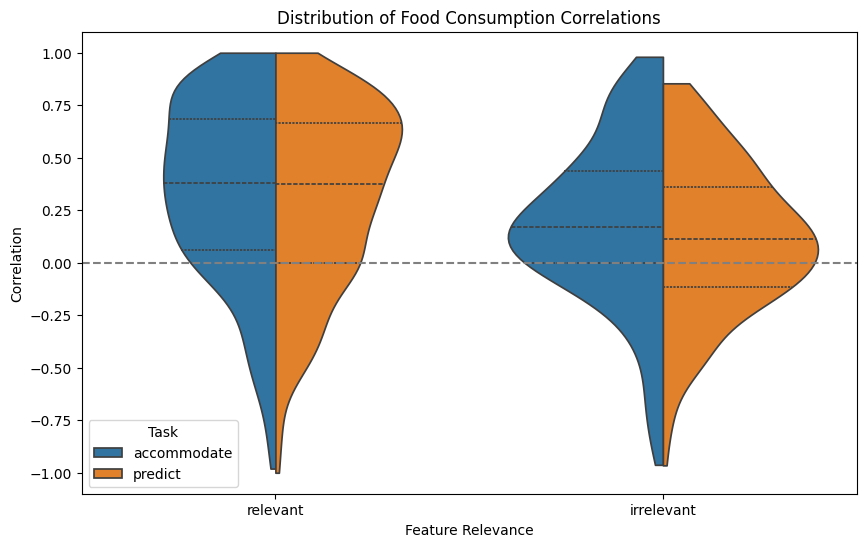

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Violin plot: distribution of ratings by task and relevance
sns.violinplot(
    data=df_corr,
    x='feature_relevance',      # relevant / irrelevant
    y='correlation',     # -7 to 7
    hue='task',                 # predict / accomodate
    split=True,                 # split the violins by hue
    inner='quartile',            # show median and quartiles
    cut = 0
)

plt.axhline(0, color='gray', linestyle='--')  # line at 0
plt.title('Distribution of Food Consumption Correlations')
plt.ylabel('Correlation')
plt.xlabel('Feature Relevance')
plt.legend(title='Task')
#plt.savefig(os.path.join(outputdir, 'Figure5_FeatureCorrelationeByTaskAndRelevanceViolin.png'), dpi=300)

plt.show()


In [202]:
avg_corr_task_rel = df_corr.groupby(
    ['task', 'feature_relevance'],
    as_index=False
)['correlation'].mean()

print(avg_corr_task_rel)


          task feature_relevance  correlation
0  accommodate        irrelevant     0.213229
1  accommodate          relevant     0.372463
2      predict        irrelevant     0.261248
3      predict          relevant     0.366378


In [31]:
nan_corrs = df_corr[pd.isna(df_corr['correlation'])]
#print(nan_corrs)
df_corr_clean = df_corr[pd.notna(df_corr['correlation'])].copy()



In [32]:
import statsmodels.formula.api as smf

md = smf.mixedlm(
    "correlation ~ task * feature_relevance",
    df_corr_clean,
    groups=df_corr_clean["participant"],  # random intercept per participant
    re_formula="~feature_relevance"  # random slopes if it converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())
mdf.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_correlation.csv"))


                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           correlation
No. Observations:            891               Method:                       REML       
No. Groups:                  297               Scale:                        0.1532     
Min. group size:             3                 Log-Likelihood:               -454.1848  
Max. group size:             3                 Converged:                    Yes        
Mean group size:             3.0                                                        
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.042    0.033  1.286 0.199 -0.022  0.106
task[T.predict]                               -

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [33]:
avg_corr_task_rel = df_corr.groupby(
    ['task'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_task_rel)
avg_corr_feature = df_corr.groupby(
    ['feature_dimension'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_feature)
avg_corr_relevance = df_corr.groupby(
    ['feature_relevance'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_relevance)
avg_corr_task_rel = df_corr.groupby(
    ['task', 'feature_relevance'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_task_rel)


          task  abs_correlation
0  accommodate         0.411739
1      predict         0.405231
  feature_dimension  abs_correlation
0             color         0.421221
1             shape         0.373962
2              tail         0.430240
  feature_relevance  abs_correlation
0        irrelevant         0.301135
1          relevant         0.462144
          task feature_relevance  abs_correlation
0  accommodate        irrelevant         0.299021
1  accommodate          relevant         0.468098
2      predict        irrelevant         0.303235
3      predict          relevant         0.456230


In [34]:
import statsmodels.formula.api as smf

md = smf.mixedlm(
    "abs_correlation ~ task * feature_relevance",
    df_corr_clean,
    groups=df_corr_clean["participant"],  # random intercept per participant
    re_formula="~feature_relevance"  # optional random slopes if it converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())


                         Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          abs_correlation
No. Observations:          891              Method:                      REML           
No. Groups:                297              Scale:                       0.0678         
Min. group size:           3                Log-Likelihood:              -92.7376       
Max. group size:           3                Converged:                   Yes            
Mean group size:           3.0                                                          
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.299    0.022 13.537 0.000  0.256  0.342
task[T.predict]                                

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Supplementary: Impact of Food Dimension

In [ ]:
# Predicting feature importance from task and feature relevance, with random intercepts for participants
md = smf.mixedlm(
    "feature_importance ~ task * feature_relevance * irrelevant_dim",
    df_long,
    groups=df_long["participant"],  # random intercept per participant
    re_formula="~feature_relevance" # random slopes
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())
mdf.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_featureimportanceWithDimensions.csv"))


                                     Mixed Linear Model Regression Results
Model:                            MixedLM                 Dependent Variable:                 feature_importance
No. Observations:                 900                     Method:                             REML              
No. Groups:                       300                     Scale:                              10.2613           
Min. group size:                  3                       Log-Likelihood:                     -2374.4307        
Max. group size:                  3                       Converged:                          Yes               
Mean group size:                  3.0                                                                           
----------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------

In [ ]:
# Predicting correlation from task and feature relevance, with random intercepts for participants

md = smf.mixedlm(
    "correlation ~ task * feature_relevance * irrelevant_dim",
    df_corr_clean,
    groups=df_corr_clean["participant"],  # random intercept per participant
    re_formula="~feature_relevance"  # optional random slopes if it converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())
mdf.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_correlationWithDimensions.csv"))


                                     Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   correlation
No. Observations:                    891                       Method:                               REML       
No. Groups:                          297                       Scale:                                0.1516     
Min. group size:                     3                         Log-Likelihood:                       -462.8681  
Max. group size:                     3                         Converged:                            Yes        
Mean group size:                     3.0                                                                        
----------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Supplementary: Irrelevant Feature Association with food amount and food consumption ratings

In [55]:
df_irrel = df_merged[df_merged['irrelevant_dim'].notna()].copy()
# Create participant identifier
df_irrel['participant'] = df_irrel['task'].astype(str) + "_" + df_irrel['conditionOrder'].astype(str)

# Pick the correct irrelevant column
def get_irrel_value(row):
    if row['irrelevant_dim'] == 'color':
        return row['color_match_high']
    elif row['irrelevant_dim'] == 'tail':
        return row['tail_match_high']
    elif row['irrelevant_dim'] == 'shape':
        return row['shape_match_high']

df_irrel['irrel_value'] = df_irrel.apply(get_irrel_value, axis=1)

# Compute correlation between food amount and the high irrelevant feature value for each participant
def compute_irrel_corr(sub):
    return sub['irrel_value'].corr(sub['food_amount'])

corrs = df_irrel.groupby('participant').apply(compute_irrel_corr).reset_index()
corrs = corrs.rename(columns={0: 'irrel_corr'})

# Merge back into df_irrel
df_irrel = df_irrel.merge(corrs, on='participant')

print(df_irrel.head(20))



           task  conditionOrder   item testing_responses relevant_dim_1  \
0   accommodate              85  N_Y_S               5.0          color   
1   accommodate              85  N_Y_C               3.0          color   
2   accommodate              85  N_B_S               6.0          color   
3   accommodate              85  N_B_C               8.0          color   
4   accommodate              85  T_B_C               6.0          color   
5   accommodate              85  T_B_S               5.0          color   
6   accommodate              85  T_Y_C               2.0          color   
7   accommodate              85  T_Y_S               2.0          color   
8   accommodate              12  T_Y_S               6.0          color   
9   accommodate              12  T_B_S               4.0          color   
10  accommodate              12  N_Y_S               8.0          color   
11  accommodate              12  N_Y_C               8.0          color   
12  accommodate          

/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_85942/843859331.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corrs = df_irrel.groupby('participant').apply(compute_irrel_corr).reset_index()


             task  conditionOrder   item testing_responses relevant_dim_1  \
1     accommodate              85  N_Y_C               3.0          color   
3     accommodate              85  N_B_C               8.0          color   
4     accommodate              85  T_B_C               6.0          color   
6     accommodate              85  T_Y_C               2.0          color   
8     accommodate              12  T_Y_S               6.0          color   
...           ...             ...    ...               ...            ...   
2390      predict              87  N_Y_C               6.0          shape   
2392      predict              13  N_B_S               6.0          shape   
2393      predict              13  N_Y_C               3.0          shape   
2394      predict              13  N_B_C               4.0          shape   
2395      predict              13  N_Y_S               5.0          shape   

     relevant_dim_2 irrelevant_dim color_high tail_high shape_high  ...  \


<Figure size 600x400 with 0 Axes>

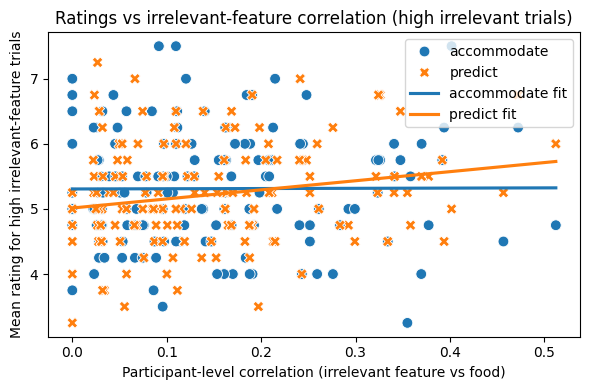

In [ ]:
# High irrelevant feature trials
high_trials = df_irrel[df_irrel['irrel_value'] == 1]
print(high_trials)

# Average rating for high-irrelevant trials per participant, keeping task
mean_high_response = high_trials.groupby(['participant', 'task'])['testing_responses'].mean().reset_index()
mean_high_response = mean_high_response.rename(columns={'testing_responses': 'mean_high_response'})

# Get participant-level irrelevant-feature correlation, also keeping task
irrel_corr = df_irrel.groupby(['participant', 'task'])['irrel_corr'].first().reset_index()

# Merge
participant_summary = mean_high_response.merge(irrel_corr, on=['participant', 'task'])

# Plot

plt.figure(figsize=(6,4))

# Scatter points
sns.scatterplot(
    data=participant_summary,
    x='irrel_corr',
    y='mean_high_response',
    hue='task',
    style='task',
    s=60
)

# Regression line per task
for task, sub in participant_summary.groupby('task'):
    sns.regplot(
        data=sub,
        x='irrel_corr',
        y='mean_high_response',
        scatter=False,
        ci=None,
        label=f"{task} fit"
    )

plt.xlabel("Participant-level correlation (irrelevant feature vs food)")
plt.ylabel("Mean rating for high irrelevant-feature trials")
plt.title("Ratings vs irrelevant-feature correlation (high irrelevant trials)")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
model = smf.ols(
    "mean_high_response ~ irrel_corr * task",
    data=participant_summary
).fit()

print(model.summary())

ValueError: endog has evaluated to an array with multiple columns that has shape (300, 18). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

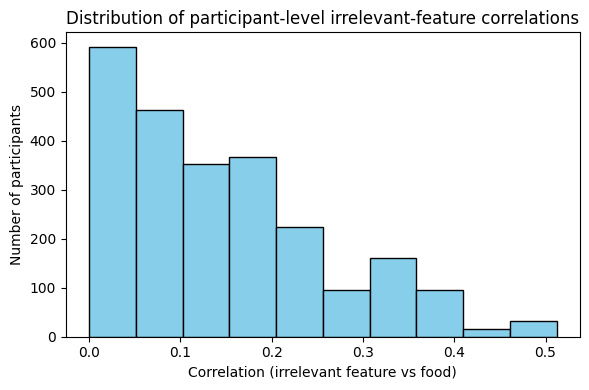

In [ ]:
import matplotlib.pyplot as plt

# Get unique correlations per participant
participant_corrs = df_irrel[['participant', 'irrel_corr']]

plt.figure(figsize=(6,4))
plt.hist(participant_corrs['irrel_corr'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Correlation (irrelevant feature vs food)")
plt.ylabel("Number of participants")
plt.title("Distribution of participant-level irrelevant-feature correlations")
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.formula.api as smf
df_irrel['testing_responses'] = pd.to_numeric(df_irrel['testing_responses'], errors='coerce')
df_irrel = df_irrel.dropna(subset=['testing_responses'])
md = smf.mixedlm(
    "testing_responses ~ task * irrel_corr",
    df_irrel,
    groups=df_irrel["participant"],    # random intercept
    re_formula="~irrel_corr"           # random slope
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())


                Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   testing_responses
No. Observations:   2400      Method:               REML             
No. Groups:         300       Scale:                3.2561           
Min. group size:    8         Log-Likelihood:       -4823.9029       
Max. group size:    8         Converged:            Yes              
Mean group size:    8.0                                              
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   5.286    0.084 62.855 0.000  5.122  5.451
task[T.predict]            -0.113    0.119 -0.946 0.344 -0.346  0.121
irrel_corr                 -0.506    0.452 -1.120 0.263 -1.391  0.379
task[T.predict]:irrel_corr  0.828    0.640  1.293 0.196 -0.427  2.082
Group Var                   0.000   

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<Figure size 600x400 with 0 Axes>

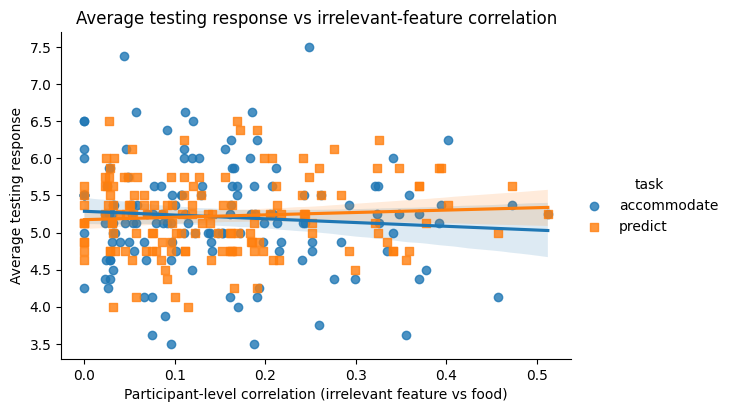

In [ ]:
import seaborn as sns
# Average trial responses per participant
participant_avg = df_irrel.groupby('participant').agg(
    mean_response=('testing_responses', 'mean'),
    irrel_corr=('irrel_corr', 'first'),   # same per participant
    task=('task', 'first')
).reset_index()
plt.figure(figsize=(6,4))
sns.lmplot(
    data=participant_avg,
    x='irrel_corr',
    y='mean_response',
    hue='task',      # regression line per task
    height=4,
    aspect=1.5,
    markers=["o","s"]
)
plt.xlabel("Participant-level correlation (irrelevant feature vs food)")
plt.ylabel("Average testing response")
plt.title("Average testing response vs irrelevant-feature correlation")
plt.show()


Supplementary Models Looking at Feature Dimension

In [ ]:
import ast
import matplotlib.pyplot as plt
#Calculate reported food amounts during testing
def AverageFoodCalclator(participants_to_use):
    df_subset = df_combined[df_combined['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        ratings     = df_subset[df_subset['participant'] == i]['testing_responses'].iloc[0]
        categories = df_subset[df_subset['participant'] == i]['testing_categories'].iloc[0]
        task = df_subset[df_subset['participant'] == i]['task'].iloc[0]
        row = df_subset[df_subset['participant'] == i].iloc[0]
        tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
        shape_yes = 1 if row['shape_discrete_slider.response'] == 'Yes' else 0
        color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0
        num_features_relevant = tail_yes + shape_yes + color_yes
        df_participant = pd.DataFrame(list(zip(
            [i]*len(ratings),  # Repeat participant ID and task to match the number of ratings
            ratings,
            [task]*len(ratings), # Repeat participant ID and task to match the number of ratings
            categories,
            [num_features_relevant]*len(ratings)
        )), columns=['participant', 'ratings', 'task', 'category', 'num_features_relevant'])
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings_cond = df_average.groupby(['task', 'category'])['ratings'].mean()
    return df_average, avg_ratings_cond

participants_to_use = df_combined['participant'].tolist()
df_average, avg_rating_cond = AverageFoodCalclator(participants_to_use)
print(avg_rating_cond)
print(df_average)
# Group by task, category, and num_features_relevant
model_parameter_score = df_average.groupby(
    ['num_features_relevant']
)['ratings'].mean().reset_index()

print(model_parameter_score)
# Group by task, category, and num_features_relevant
avg_ratings_cond_by_relevance = df_average.groupby(
    ['task', 'category', 'num_features_relevant']
)['ratings'].mean().reset_index()


print(avg_ratings_cond_by_relevance)
category_order = ['low', 'medium', 'high']
avg_ratings_cond_by_relevance['category'] = pd.Categorical(
    avg_ratings_cond_by_relevance['category'],
    categories=category_order,
    ordered=True
)
import seaborn as sns
sns.catplot(
    data=avg_ratings_cond_by_relevance,
    x='category', y='ratings',
    hue='num_features_relevant', col='task',
    kind='bar', palette='Set2'
)
plt.show()

<Axes: xlabel='category', ylabel='ratings'>

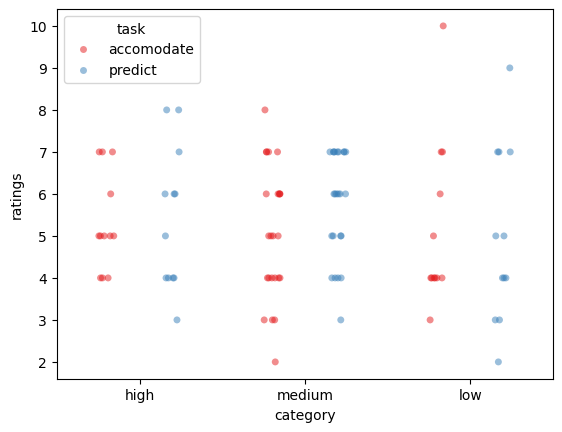

In [ ]:
sns.stripplot(data=df_average, x='category', y='ratings', hue='task', 
              palette='Set1', dodge=True, jitter=True, color='black', alpha=0.5)

In [ ]:
print(df_average.head(20))

    participant  ratings        task category  num_features_relevant
0             1      6.0  accomodate     high                      1
1             1      5.0  accomodate   medium                      1
2             1      3.0  accomodate      low                      1
3             1      5.0  accomodate   medium                      1
4             1      5.0  accomodate   medium                      1
5             1      7.0  accomodate     high                      1
6             1      4.0  accomodate      low                      1
7             1      4.0  accomodate   medium                      1
8             2      5.0  accomodate   medium                      2
9             2      3.0  accomodate   medium                      2
10            2      5.0  accomodate     high                      2
11            2      7.0  accomodate      low                      2
12            2      7.0  accomodate     high                      2
13            2      5.0  accomoda

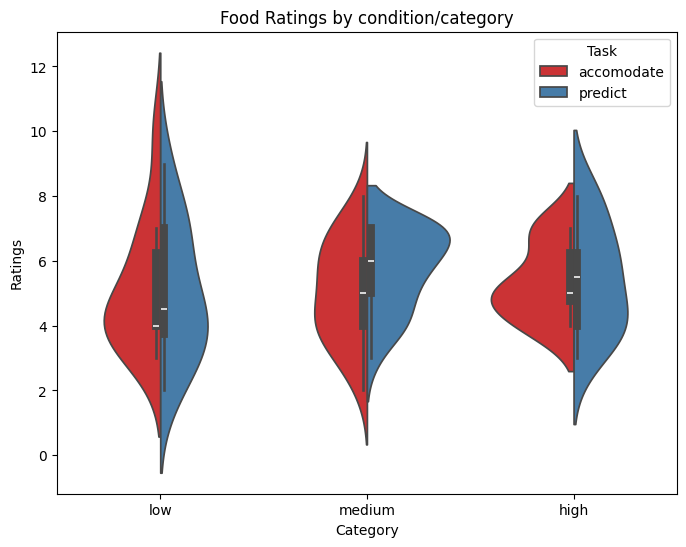

In [ ]:
order = ['low', 'medium', 'high']
# Violin plot: ratings by category, separated by task
plt.figure(figsize=(8,6))
sns.violinplot(
    data=df_average,
    x='category',       # x-axis: categories
    y='ratings',        # y-axis: ratings
    hue='task',         # split by task
    split=True,         # split the violins by task
    palette='Set1',
    inner='box',    # show box plot of data inside
    order = order
)

plt.ylabel('Ratings')
plt.xlabel('Category')
plt.title('Food Ratings by condition/category')
plt.legend(title='Task')
#plt.savefig(f'{study}Plots/ViolinRatings.png', bbox_inches='tight')
plt.show()

In [ ]:
def decode_rel(rel_values):
    """
    rel_values: Series of lists of rel codes
    """

    flat_vals = []
    for v in rel_values:
        if isinstance(v, list):
            flat_vals.extend(v)

    flat_vals = pd.Series(flat_vals).dropna().unique()

    if len(flat_vals) == 0:
        return pd.Series({'feature_relevance': np.nan})

    # irrelevant: only I-codes
    if all(v.startswith('I') for v in flat_vals):
        return pd.Series({'feature_relevance': 'irrelevant'})

    # relevant: contains R or L
    if any(v.startswith(('R', 'L')) for v in flat_vals):
        return pd.Series({'feature_relevance': 'relevant'})

    raise ValueError(f"Unexpected rel codes: {flat_vals}")


feature_relevance_rows = []

for (cond, task), subdf in df_combined.groupby(['conditionOrder', 'task']):
    for feat in ['tail', 'color', 'shape']:
        relevance = decode_rel(subdf[f'training_{feat}'])

        feature_relevance_rows.append({
            'conditionOrder': cond,
            'task': task,
            'feature_dimension': feat,
            'feature_relevance': relevance
        })

df_feature_relevance = pd.DataFrame(feature_relevance_rows)
print(df_feature_relevance)

    conditionOrder        task feature_dimension  \
0                1  accomodate              tail   
1                1  accomodate             color   
2                1  accomodate             shape   
3                1     predict              tail   
4                1     predict             color   
5                1     predict             shape   
6                2  accomodate              tail   
7                2  accomodate             color   
8                2  accomodate             shape   
9                2     predict              tail   
10               2     predict             color   
11               2     predict             shape   
12               3  accomodate              tail   
13               3  accomodate             color   
14               3  accomodate             shape   
15               3     predict              tail   
16               3     predict             color   
17               3     predict             shape   
18          

In [ ]:
features = ['shape', 'color', 'tail']
long_rows = []

for _, row in df_combined.iterrows():
    for feat in features:
        long_rows.append({
            'participant': row['participant'],
            'conditionOrder': row['conditionOrder'],
            'task': row['task'],
            'feature_dimension': feat,

            'discrete': row[f'{feat}_discrete_slider.response'],
            'direction': row[f'{feat}_direction_slider.response'],
            'continuous': row[f'{feat}_continuous_slider.response'],
        })

df_long = pd.DataFrame(long_rows)
print(df_long.head(10))

   participant  conditionOrder        task feature_dimension discrete  \
0            1               4  accomodate             shape      Yes   
1            1               4  accomodate             color       No   
2            1               4  accomodate              tail       No   
3            2               1  accomodate             shape       No   
4            2               1  accomodate             color      Yes   
5            2               1  accomodate              tail      Yes   
6            3               3  accomodate             shape      Yes   
7            3               3  accomodate             color      Yes   
8            3               3  accomodate              tail      Yes   
9            4               2  accomodate             shape      Yes   

       direction  continuous  
0         Square         5.0  
1            NaN         NaN  
2            NaN         NaN  
3            NaN         NaN  
4           Blue         4.0  
5  Having 

In [ ]:
df_long = df_long.merge(
    df_feature_relevance,
    on=['conditionOrder', 'task', 'feature_dimension'],
    how='left'
)
print(df_long.head(21))

    participant  conditionOrder        task feature_dimension discrete  \
0             1               4  accomodate             shape      Yes   
1             1               4  accomodate             color       No   
2             1               4  accomodate              tail       No   
3             2               1  accomodate             shape       No   
4             2               1  accomodate             color      Yes   
5             2               1  accomodate              tail      Yes   
6             3               3  accomodate             shape      Yes   
7             3               3  accomodate             color      Yes   
8             3               3  accomodate              tail      Yes   
9             4               2  accomodate             shape      Yes   
10            4               2  accomodate             color      Yes   
11            4               2  accomodate              tail      Yes   
12            5               2     pr